# Manual Synchronization steps - only use when needed and after block instantiation

In [5]:
block.get_eyes_diff_list(2)

index error on position 66 out of 67
index error on position 116 out of 117
The suspected lag between eye cameras is -34.0 with the direction ['right', 'early']


In [6]:
block.fix_eye_synchronization()

created manual_sync_df attribute for the block


In [7]:
block.manual_sync_df

,Arena_TTL,Arena_frame,L_eye_frame,R_eye_frame,L_values,R_values
0,461193.0,592.0,1.0,NaN,-1.719365,NaN
1,461533.0,593.0,2.0,NaN,-1.713026,NaN
2,461872.0,594.0,3.0,NaN,-1.705531,NaN
3,462212.0,595.0,4.0,NaN,-1.702933,NaN
4,462552.0,596.0,5.0,NaN,-1.697936,NaN
...,...,...,...,...,...,...
253316,86465528.0,253908.0,258481.0,258483.0,0.251716,-1.157362
253317,86465867.0,253909.0,258482.0,258484.0,0.252264,-1.156074
253318,86466207.0,253910.0,258483.0,258485.0,0.257629,-1.157538
253319,86466546.0,253911.0,258484.0,258486.0,0.257683,-1.157518


In [11]:
# use this to manually shift L\R eye synchronization
eye_to_move = 'R'
block.move_eye_sync_manual(cols_to_move=[f'{eye_to_move}_eye_frame',f'{eye_to_move}_values'],step=-5 )

In [12]:
block.full_sync_verification(ms_axis=False,with_arena=False)

In [13]:
block.export_manual_sync_df()
block.import_manual_sync_df()

# Start Here

In [3]:
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns

In [4]:
def create_distance_plot(distances, top_dist_to_show=500):
    # Create cumulative distribution plot
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(2, figsize=(6, 6), dpi=150)
    
    axs[0].set_title('Cumulative Euclidean Distances for Camera Jitter', fontsize=15)
    axs[0].set_ylabel('Cumulative \n % of Frames')
    axs[0].set_xlim(0, top_dist_to_show)
    axs[0].grid(False)
    
    # Create histogram and cumulative distribution
    sns.kdeplot(distances, cumulative=True, label='Left Eye', ax=axs[0], linewidth=4, c='black')
    
    axs[1].hist(distances, bins=np.linspace(0, top_dist_to_show, 20), log=False, color='black')

    # Set title and labels
    title = 'Image displacement histogram'
    axs[1].set_title(title, fontsize=15)
    axs[1].set_xlabel('Euclidean Displacement [$\mu$m]', fontsize=15)
    axs[1].set_xscale('linear')
    axs[1].set_yscale('linear')
    axs[1].set_ylabel('Frame count', fontsize=15)

    # Adjust tick label sizes
    axs[1].tick_params(axis='x', which='major', labelsize=15)

    # Set white background and black text
    axs[1].set_facecolor('white')
    axs[1].title.set_color('black')
    axs[1].xaxis.label.set_color('black')
    axs[1].yaxis.label.set_color('black')
    axs[1].tick_params(colors='black')
    axs[1].grid(False)

    plt.tight_layout()

    return fig, axs
def add_intermediate_elements(input_vector, gap_to_bridge):
    # Step 1: Calculate differences between each element
    differences = np.diff(input_vector)

    # Step 2: Add intervening elements based on the diff_threshold
    output_vector = [input_vector[0]]
    for i, diff in enumerate(differences):
        if diff < gap_to_bridge:
            # Add intervening elements
            output_vector.extend(range(input_vector[i] + 1, input_vector[i + 1]))

        # Add the next element from the original vector
        output_vector.append(input_vector[i + 1])

    return np.sort(np.unique(output_vector))

def find_jittery_frames(block, eye, max_distance, diff_threshold, gap_to_bridge=6):
    
    #input checks
    if eye not in ['left', 'right']:
        print(f'eye can only be left/right, your input: {eye}')
        return None
    # eye setup
    if eye == 'left':
        jitter_dict = block.le_jitter_dict
        eye_frame_col = 'L_eye_frame'
    elif eye == 'right':
        jitter_dict = block.re_jitter_dict
        eye_frame_col = 'R_eye_frame'
    
    df_dict = {'left':block.le_df,
               'right':block.re_df}
    
    df = pd.DataFrame.from_dict(jitter_dict)
    indices_of_highest_drift = df.query("top_correlation_dist > @max_distance").index.values
    diff_vec = np.diff(df['top_correlation_dist'].values)
    diff_peaks_indices = np.where(diff_vec > diff_threshold)[0]
    video_indices = np.concatenate((diff_peaks_indices, indices_of_highest_drift))
    print(f'the diff based jitter frame exclusion gives: {np.shape(diff_peaks_indices)}')
    print(f'the threshold based jitter frame exclusion gives: {np.shape(indices_of_highest_drift)}')
    
    # creates a bridged version of the overly jittery frames (to contend with single frame outliers)
    video_indices = add_intermediate_elements(video_indices, gap_to_bridge=gap_to_bridge)
    # This is the input you should give to the BlockSync.remove_eye_datapoints function (which already maps it to the df) 
    
    
    # translates the video indices to le/re dataframe rows
    df_indices_to_remove = df_dict[eye].loc[df_dict[eye][eye_frame_col].isin(video_indices)].index.values
    
    return df_indices_to_remove, video_indices

def bokeh_plotter(data_list, label_list,
                  plot_name='default',
                  x_axis='X', y_axis='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis,
                                y_axis_label=y_axis,
                                plot_width=1500,
                                plot_height=700)

    for i, vec in enumerate(range(len(data_list))):
        color = next(color_cycle)
        data_vector = data_list[vec]
        if label_list is None:
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"Line {len(fig.renderers)}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    
def play_video_with_ellipses_rotation(block, eye, path_to_video=False, xflip=False, transformation_matrix=None):
    if eye == 'left':
        video_path = block.le_videos[0]
        ellipse_dataframe = block.left_eye_data
    elif eye == 'right':
        video_path = block.re_videos[0]
        ellipse_dataframe = block.right_eye_data
    else:
        raise ValueError(f"eye can only be 'left' or 'right'")
    
    if video_path is not False:
        video_path = path_to_video

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file.")
        return

    # Loop through each frame
    while True:
        # Read a frame from the video
        ret, frame = cap.read()
    
        if not ret:
            # Break the loop if the video is finished
            break
        
        # Optionally flip the frame along the x-axis
        if xflip:
            frame = cv2.flip(frame, 1)

        # Apply transformation matrix if provided
        if transformation_matrix is not None:
            frame = cv2.warpAffine(frame, transformation_matrix, (frame.shape[1], frame.shape[0]))

        # Get the corresponding ellipse data for the current frame
        current_frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
        try:
            current_frame_data = ellipse_dataframe.iloc[ellipse_dataframe.query('eye_frame == @current_frame_num').index[0]]
        except IndexError:
            continue

        # Extract ellipse parameters
        if transformation_matrix is not None:
            try:
                center_x = int(current_frame_data['center_x'])
                center_y = int(current_frame_data['center_y'])
                width = int(current_frame_data['width'])
                height = int(current_frame_data['height'])
                phi = np.deg2rad(float(current_frame_data['phi']))
                
                # Draw the ellipse on the frame
                cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
                
                # Add text to the frame
                text = f'ellipse angle: {phi}'
                cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        
                
                # Display the frame
                cv2.imshow('Video with Ellipses', frame)
            
                # Check for the 'q' key to quit
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            except ValueError:
                continue
        else:
            try:
                center_x = int(current_frame_data['center_x'])
                center_y = int(current_frame_data['center_y'])
                width = int(current_frame_data['width'])
                height = int(current_frame_data['height'])
                phi = np.deg2rad(float(current_frame_data['phi']))
        
                # Draw the ellipse on the frame
                cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
                
                # Add text to the frame
                text = f'ellipse angle: {phi}'
                cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                
                # Display the frame
                cv2.imshow('Video with Ellipses', frame)
            
                # Check for the 'q' key to quit
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            except ValueError:
                continue

    # Release video capture object and close the window
    cap.release()
    cv2.destroyAllWindows()
    
def play_video_with_ellipses_rotation_plus_major_axis(block, eye, path_to_video=False, xflip=False, transformation_matrix=None):
    if eye == 'left':
        video_path = block.le_videos[0]
        ellipse_dataframe = block.left_eye_data
    elif eye == 'right':
        video_path = block.re_videos[0]
        ellipse_dataframe = block.right_eye_data
    else:
        raise ValueError(f"eye can only be 'left' or 'right'")
    
    if video_path is not False:
        video_path = path_to_video

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file.")
        return

    # Loop through each frame
    while True:
        # Read a frame from the video
        ret, frame = cap.read()
    
        if not ret:
            # Break the loop if the video is finished
            break
        
        # Optionally flip the frame along the x-axis
        if xflip:
            frame = cv2.flip(frame, 1)

        # Apply transformation matrix if provided
        if transformation_matrix is not None:
            frame = cv2.warpAffine(frame, transformation_matrix, (frame.shape[1], frame.shape[0]))

        # Get the corresponding ellipse data for the current frame
        current_frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
        try:
            current_frame_data = ellipse_dataframe.iloc[ellipse_dataframe.query('eye_frame == @current_frame_num').index[0]]
        except IndexError:
            continue

        # Extract ellipse parameters
        try:
            center_x = int(current_frame_data['center_x'])
            center_y = int(current_frame_data['center_y'])
            width = int(current_frame_data['major_ax'])
            height = int(current_frame_data['minor_ax'])
            phi = np.deg2rad(float(current_frame_data['phi']))  # Convert angle to radians
            
            # Draw the ellipse on the frame
            cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
            
            # Calculate endpoints of major axis
            axis_length = max(width, height) / 2
            sin_phi = np.sin(phi)
            cos_phi = np.cos(phi)
            x1 = int(center_x + axis_length * cos_phi)
            y1 = int(center_y + axis_length * sin_phi)
            x2 = int(center_x - axis_length * cos_phi)
            y2 = int(center_y - axis_length * sin_phi)
            
            # Draw major axis
            cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
            
            # Add text to the frame
            text = f'ellipse angle: {np.rad2deg(phi)}'
            cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            
            # Display the frame
            cv2.imshow('Video with Ellipses', frame)
        
            # Check for the 'q' key to quit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        except ValueError:
            continue

    # Release video capture object and close the window
    cap.release()
    cv2.destroyAllWindows()
    
def get_frame_count(video_path):
        """
        Get the number of frames for the video in the specified path using OpenCV.
    
        Parameters:
            video_path (str): Path to the video file.
    
        Returns:
            int: Number of frames in the video.
        """
        # Open the video file
        cap = cv2.VideoCapture(video_path)
    
        # Check if the video file is opened successfully
        if not cap.isOpened():
            print("Error: Could not open the video file.")
            return -1
    
        # Get the total number of frames in the video
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
        # Release the VideoCapture object
        cap.release()
    
        return frame_count


# Block Instantiation

In [13]:
# define a single block to synchronize and finally export l/r_eye_data csv files:
# this step creates block_collection - a list of BlockSync objects of interest
block_numbers = [23,24,25,26,27,38,39,40,41,57]
bad_blocks = [42, 43, 45, 46, 61, 62, 64, 65, 66] # True for PV_62
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = 'PV_62'
block_collection = uf.block_generator(block_numbers=block_numbers,
                                      experiment_path=experiment_path,
                                      animal=animal,
                                      bad_blocks=bad_blocks)
# create a block_dict object for ease of access:
block_dict = {}
for b in block_collection:
    block_dict[str(b.block_num)] = b
block = block_collection[0]

instantiated block number 023 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_023, new OE version
Found the sample rate for block 023 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 023
got it!
instantiated block number 024 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_024, new OE version
Found the sample rate for block 024 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 024
got it!
instantiated block number 025 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_025, new OE version
Found the sample rate for block 025 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 025
got it!
instantiated block number 026 at Path: Z:\Nimrod\experi

# Side quest - verify the arena video's synchronization by trigger counting and comparing with the video frames:

In [ ]:
# create Mark's ground-truth table
trig_df = pd.read_csv(r'Z:\Nimrod\HelperFiles\trigger_count_table.csv')
frame_count_df = pd.read_csv(r'Z:\Nimrod\HelperFiles\frame_count_table.csv')
as_paths = [pathlib.Path(p) for p in frame_count_df.Var1.values]
frame_count_df['block_num'] = [i.parent.parent.parent.name[-3:] for i in as_paths]
trig_as_paths = [pathlib.Path(p) for p in trig_df.Var1.values]
trig_df['block_num'] = [i.parent.parent.parent.name[-3:] for i in trig_as_paths]
frame_trig_report = pd.merge(frame_count_df, trig_df, on='block_num', how='left')
frame_trig_report = frame_trig_report.rename(columns={'Var2':'frame_count_mark', 'Var1_x':'vid_name','trig_count':'trig_count_mark','block_num':'block_number'})
frame_trig_report['vid_name'] = [str(pathlib.Path(vid_name).name) for vid_name in frame_trig_report.vid_name.values]
frame_trig_report.drop(columns=['Var1_y'],inplace=True)



In [ ]:
#df_blocks = df_blocks.rename(columns={'block number':'block_number', 'trigger count':'trigger_count'})
report = pd.merge(frame_trig_report, df_blocks, on='block_number', how='left')
report['synced_block'] = [report.frame_count_mark.values == report.trig_count_mark.values]

In [ ]:
frame_trig_report['missing_frames'] = frame_trig_report.trig_count_mark.values - frame_trig_report.frame_count_mark.values
frame_trig_report.to_csv(r'Z:\Nimrod\HelperFiles\frame_trig_report.csv')

In [4]:
#block = block_collection[0]
for block in block_collection:
        
    block.handle_arena_files()
    print(block)
    df = pd.read_csv(block.block_path / rf'oe_files' / block.exp_date_time / 'events.csv')
    channels = np.unique(df['line'].to_numpy(copy=True))
    df_onstate = df[df['state'] == 1]
    
    all_triggers = pd.Series(df_onstate['sample_number'][df_onstate['line'] == 1])
    diff_arr = np.diff(s.values) // 20
    arena_start_stop = np.where(diff_arr > 1000)[0]
    start_ind = arena_start_stop[0] +1
    end_ind = arena_start_stop[-1]
    arena_start_timestamp = s.iloc[[start_ind]]
    arena_end_timestamp = s.iloc[end_ind]
    trigger_count = len(s.values[start_ind:end_ind])
    frame_count = get_frame_count(str(block.arena_videos[0]))
    print('Frame count: ',frame_count)
    print('trigger count: ',trigger_count)


In [ ]:
# Initialize an empty list to store data for each block
block_data = []

for block in block_collection:
    # block.handle_arena_files()
    #print(block)
    df = pd.read_csv(block.block_path / rf'oe_files' / block.exp_date_time / 'events.csv')
    channels = np.unique(df['line'].to_numpy(copy=True))
    df_onstate = df[df['state'] == 1]
    
    s = pd.Series(df_onstate['sample_number'][df_onstate['line'] == 1])
    
    diff_arr = np.diff(s.values) / (block.sample_rate / 1000) 
    arena_start_stop = np.where(diff_arr > 1000)[0]
    option_count = len(arena_start_stop)
    if option_count > 2:
        # max_diff logic:
        ind_max_diff = np.argmax(np.diff(arena_start_stop))
        start_ind = arena_start_stop[ind_max_diff]
        end_ind = arena_start_stop[ind_max_diff + 1] 
        
    elif option_count == 2:
        start_ind = arena_start_stop[0]
        end_ind = arena_start_stop[-1]      
        
    arena_start_timestamp = s.iloc[[start_ind]]
    arena_end_timestamp = s.iloc[end_ind]
    trigger_count = len(s.values[start_ind:end_ind]) + 1
    frame_count_list = []
    for vid in block.arena_videos:
        frame_count = get_frame_count(str(vid))
        frame_count_list.append(frame_count)
    
    # Calculate the difference between frame count and trigger count
    trigger_diff = frame_count - trigger_count
    
    # Append data for the current block to the list of dictionaries
    block_data.append({
        'block number': block.block_num,
        'options': option_count,
        'frame count': frame_count_list,
        'trigger count': trigger_count,
        'trigger diff': trigger_diff
    })

# Convert the list of dictionaries to a pandas DataFrame
df_blocks = pd.DataFrame(block_data)

# Display the DataFrame
print(df_blocks)


### Re-Calibration step, using the caudal-rostral edge mean distance

In [14]:
# This bit of code goes over blocks and collects the median distance between the rostral and caudal edges
import os
from ellipse import LsqEllipse
import scipy.stats as stats

def eye_tracking_analysis(dlc_video_analysis_csv, uncertainty_thr):
    """
    :param dlc_video_analysis_csv: the csv output of a dlc analysis of one video, already read by pandas with header=1
    :param uncertainty_thr: The confidence P value to use as a threshold for datapoint validity in the analysis
    :returns ellipse_df: a DataFrame of ellipses parameters (center, width, height, phi, size) for each video frame

    """
    # import the dataframe and convert it to floats
    data = dlc_video_analysis_csv
    data = data.iloc[1:].apply(pd.to_numeric)

    # sort the pupil elements to dfs: x and y, with p as probability
    pupil_elements = np.array([x for x in data.columns if 'Pupil' in x])

    # get X coords
    pupil_xs_before_flip = data[pupil_elements[np.arange(0, len(pupil_elements), 3)]]

    # flip the data around the midpoint of the x-axis (shooting the eye through a camera flips right and left)
    pupil_xs = 320 * 2 - pupil_xs_before_flip

    # get Y coords (no need to flip as opencv conventions already start with origin at top left of frame
    # and so, positive Y is maintained as up in a flipped image as we have)
    pupil_ys = data[pupil_elements[np.arange(1, len(pupil_elements), 3)]]
    pupil_ps = data[pupil_elements[np.arange(2, len(pupil_elements), 3)]]

    # rename dataframes for masking with p values of bad points:
    pupil_ps = pupil_ps.rename(columns=dict(zip(pupil_ps.columns, pupil_xs.columns)))
    pupil_ys = pupil_ys.rename(columns=dict(zip(pupil_ys.columns, pupil_xs.columns)))
    good_points = pupil_ps > uncertainty_thr
    pupil_xs = pupil_xs[good_points]
    pupil_ys = pupil_ys[good_points]

    # Do the same for the edges
    edge_elements = np.array([x for x in data.columns if 'edge' in x])
    edge_xs_before_flip = data[edge_elements[np.arange(0, len(edge_elements), 3)]]
    edge_xs = 320*2 - edge_xs_before_flip
    edge_ys = data[edge_elements[np.arange(1, len(edge_elements), 3)]]
    edge_ps = data[edge_elements[np.arange(2,len(edge_elements),3)]]
    edge_ps = edge_ps.rename(columns=dict(zip(edge_ps.columns,edge_xs.columns)))
    edge_ys = edge_ys.rename(columns=dict(zip(edge_ys.columns,edge_xs.columns)))
    good_edge_points = edge_ps < uncertainty_thr
    
    # work row by row to figure out the ellipses
    ellipses = []
    caudal_edge_ls = []
    rostral_edge_ls = []
    for row in tqdm.tqdm(range(1, len(data) - 1)):
        # first, take all the values, and concatenate them into an X array
        x_values = pupil_xs.loc[row].values
        y_values = pupil_ys.loc[row].values
        X = np.c_[x_values, y_values]

        # now, remove nan values, and check if there are enough points to make the ellipse
        X = X[~ np.isnan(X).any(axis=1)]

        # if there are enough rows for a fit, make an ellipse
        if X.shape[0] > 5:
            el = LsqEllipse().fit(X)
            center, width, height, phi = el.as_parameters()
            center_x = center[0]
            center_y = center[1]
            ellipses.append([center_x, center_y, width, height, phi])
        else:
            ellipses.append([np.nan, np.nan, np.nan, np.nan, np.nan])

        caudal_edge = [
            float(data['Caudal_edge'][row]),
            float(data['Caudal_edge.1'][row])
        ]
        rostral_edge = [
            float(data['Rostral_edge'][row]),
            float(data['Rostral_edge.1'][row])
        ]
        caudal_edge_ls.append(caudal_edge)
        rostral_edge_ls.append(rostral_edge)


    ellipse_df = pd.DataFrame(columns=['center_x', 'center_y', 'width', 'height', 'phi'], data=ellipses)
    a = np.array(ellipse_df['height'][:])
    b = np.array(ellipse_df['width'][:])
    ellipse_size_per_frame = a * b * math.pi
    ellipse_df['ellipse_size'] = ellipse_size_per_frame
    ellipse_df['rostral_edge'] = rostral_edge_ls
    ellipse_df['caudal_edge'] = caudal_edge_ls

    print(f'\n ellipses calculation complete')
    
    ellipse_df[['caudal_edge_x', 'caudal_edge_y']] = pd.DataFrame(ellipse_df['caudal_edge'].tolist(), index=ellipse_df.index)
    ellipse_df[['rostral_edge_x', 'rostral_edge_y']] = pd.DataFrame(ellipse_df['rostral_edge'].tolist(), index=ellipse_df.index)
    
    return ellipse_df

def get_pixel_distance(df):
    distances = np.sqrt((df['caudal_edge_x'] - df['rostral_edge_x'])**2 + 
                        (df['caudal_edge_y'] - df['rostral_edge_y'])**2)
    
    mean_distance = np.nanmean(distances)
    std_distance = np.nanstd(distances)
    # Shapiro-Wilk Test
    shapiro_test = stats.shapiro(distances)
    print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")
    
    # Kolmogorov-Smirnov Test
    ks_test = stats.kstest(distances, 'norm', args=(mean_distance, std_distance))
    print(f"Kolmogorov-Smirnov Test: Statistic={ks_test.statistic}, p-value={ks_test.pvalue}")
    
    median_distance = np.median(distances)
    iqr_distance = stats.iqr(distances)
    print(f"Median Distance: {median_distance}")
    print(f"IQR: {iqr_distance}")
    print(f'mean = {mean_distance}')
    print(f'std = {std_distance}')
    return median_distance

R_pix_distance_dict = {}
L_pix_distance_dict = {}

for block in block_collection:
    print(f'working on {block}')
    pl = [i for i in os.listdir(block.r_e_path) if 'DLC' in i and '.csv' in i]
    if len(pl) > 1:
        pl = [i for i in pl if 'filtered' in i][0]
    else:
        pl = pl[0]
    R_csv  = pd.read_csv(block.r_e_path / pl, header=1)
    
    pl = [i for i in os.listdir(block.l_e_path) if 'DLC' in i and '.csv' in i]
    if len(pl) > 1:
        pl = [i for i in pl if 'filtered' in i][0]
    else:
        pl = pl[0]
    L_csv  = pd.read_csv(block.l_e_path / pl, header=1)
    R_ellipse_df = eye_tracking_analysis(R_csv,0.998)
    print('working on the right eye')
    R_pixel_distance = get_pixel_distance(R_ellipse_df)    
    L_ellipse_df = eye_tracking_analysis(L_csv,0.998)
    print('working on the left eye')
    L_pixel_distance = get_pixel_distance(L_ellipse_df)
    R_pix_distance_dict[block.block_num] = R_pixel_distance
    L_pix_distance_dict[block.block_num] = L_pixel_distance
    

working on PV_62, block 023, on 2023-04-27_10-52-42


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 97327/97327 [01:00<00:00, 1604.06it/s]



 ellipses calculation complete
working on the right eye
Shapiro-Wilk Test: Statistic=0.6651073694229126, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.0910954139005472, p-value=0.0
Median Distance: 188.7885736307406
IQR: 7.09907460928423
mean = 189.09930987276724
std = 7.724918970272917


C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
100%|██████████| 97329/97329 [01:01<00:00, 1585.67it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.9053123593330383, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.1262705455781098, p-value=0.0
Median Distance: 173.80299589396697
IQR: 10.482427726217821
mean = 176.15871814048378
std = 9.177955410525046
working on PV_62, block 024, on 2023-04-27_11-22-56


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 95743/95743 [01:00<00:00, 1576.52it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the right eye
Shapiro-Wilk Test: Statistic=0.6245929598808289, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.14208197681039697, p-value=0.0
Median Distance: 189.2123839081111
IQR: 6.513502288448365
mean = 189.15773586342294
std = 8.325302546328661


100%|██████████| 95742/95742 [01:00<00:00, 1576.14it/s]



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.9535509943962097, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.09942581255813338, p-value=0.0
Median Distance: 177.2764923716812
IQR: 16.86535061976653
mean = 179.9156970706592
std = 10.950951180092478
working on PV_62, block 025, on 2023-04-27_11-52-05


C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 96568/96568 [01:00<00:00, 1595.51it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the right eye
Shapiro-Wilk Test: Statistic=0.5161051750183105, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.11810346341119571, p-value=0.0
Median Distance: 188.3822911740869
IQR: 6.859314689537058
mean = 188.0098072392268
std = 7.760994427875696


100%|██████████| 96576/96576 [01:01<00:00, 1565.01it/s]



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.9440450668334961, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.08816139420977981, p-value=0.0
Median Distance: 177.32252019229787
IQR: 12.570833247600802
mean = 179.24608595236157
std = 8.95100357809381
working on PV_62, block 026, on 2023-04-27_12-21-41


C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 107638/107638 [01:07<00:00, 1591.59it/s]



 ellipses calculation complete
working on the right eye
Shapiro-Wilk Test: Statistic=0.7597370147705078, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.10197969296799225, p-value=0.0
Median Distance: 190.7805660516093
IQR: 5.4654314019092
mean = 191.20334006753754
std = 5.818945530118169


C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
100%|██████████| 107640/107640 [01:07<00:00, 1585.79it/s]



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.9770314693450928, p-value=0.0


C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Kolmogorov-Smirnov Test: Statistic=0.055452810053221946, p-value=3.89568139296348e-288
Median Distance: 180.72575936032234
IQR: 16.261037660159275
mean = 181.94717280104354
std = 10.46236624202547
working on PV_62, block 027, on 2023-04-27_12-53-31


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 91389/91389 [00:57<00:00, 1590.83it/s]



 ellipses calculation complete
working on the right eye
Shapiro-Wilk Test: Statistic=0.8720362186431885, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.06803619483450246, p-value=0.0
Median Distance: 187.68104903311806
IQR: 6.114231360765558
mean = 188.11315976223838
std = 5.387752714789968


C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
100%|██████████| 91388/91388 [00:57<00:00, 1583.16it/s]



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.961141049861908, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.07706587839653795, p-value=0.0
Median Distance: 183.98369179740865
IQR: 19.858679980591575
mean = 184.8340829420713
std = 11.073938925315135
working on PV_62, block 038, on 2023-05-01_13-57-45


C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 160085/160085 [01:41<00:00, 1583.74it/s]



 ellipses calculation complete
working on the right eye


C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk Test: Statistic=0.8244919180870056, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.06738684782636195, p-value=0.0
Median Distance: 181.68295480688457
IQR: 6.906849881145035
mean = 182.179541325759
std = 6.296226381790938


100%|██████████| 160085/160085 [01:39<00:00, 1602.48it/s]



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.6405868530273438, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.16346023684446848, p-value=0.0
Median Distance: 169.35741315140626
IQR: 19.991051156073098
mean = 173.21910591320608
std = 17.979183642219578
working on PV_62, block 039, on 2023-05-01_14-44-23


C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 220061/220061 [02:19<00:00, 1579.12it/s]



 ellipses calculation complete
working on the right eye
Shapiro-Wilk Test: Statistic=0.9630381464958191, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.041056933525169814, p-value=0.0
Median Distance: 181.61817322199568
IQR: 6.738980978464014
mean = 181.91883187970777
std = 5.49816930866089


C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
100%|██████████| 220078/220078 [02:18<00:00, 1590.30it/s]



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.9211226105690002, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.1370484332986348, p-value=0.0
Median Distance: 169.8729495000527
IQR: 17.734711621125626
mean = 173.3929224088209
std = 10.231995770196765
working on PV_62, block 040, on 2023-05-01_15-49-30


C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 242559/242559 [02:22<00:00, 1707.45it/s]



 ellipses calculation complete
working on the right eye
Shapiro-Wilk Test: Statistic=0.5348605513572693, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.28598178836868443, p-value=0.0
Median Distance: 181.9342540005316
IQR: 7.329493769851638
mean = 182.63817887734464
std = 23.9379417209854


C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
100%|██████████| 242565/242565 [02:32<00:00, 1592.09it/s]



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.8467341065406799, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.08835783726635799, p-value=0.0
Median Distance: 174.56293266165017
IQR: 19.68013313127085
mean = 176.79329907150768
std = 13.788547655939356
working on PV_62, block 041, on 2023-05-01_16-58-39


C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 115219/115219 [01:01<00:00, 1876.25it/s]



 ellipses calculation complete
working on the right eye


C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk Test: Statistic=0.6663854718208313, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.3051625799613482, p-value=0.0
Median Distance: 179.67775944719529
IQR: 8.14283731758377
mean = 174.2869345330258
std = 23.438662530384892


100%|██████████| 115244/115244 [01:13<00:00, 1578.53it/s]



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.9357619881629944, p-value=0.0

C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Kolmogorov-Smirnov Test: Statistic=0.12129297137250178, p-value=0.0
Median Distance: 181.70848224461747
IQR: 24.243280665098467
mean = 181.02709575453898
std = 13.598933275123311
working on PV_62, block 057, on 2023-05-08_12-17-49


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 217114/217114 [01:40<00:00, 2154.47it/s]



 ellipses calculation complete
working on the right eye
Shapiro-Wilk Test: Statistic=0.31398844718933105, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.35329818041416994, p-value=0.0
Median Distance: 185.16271517204336
IQR: 5.824989410998398
mean = 182.939770481461
std = 20.88579822465177


C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
100%|██████████| 217119/217119 [02:16<00:00, 1595.51it/s]



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.8980422019958496, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.06674276064024842, p-value=0.0
Median Distance: 188.48930524358673
IQR: 10.403814734098972
mean = 189.59567325510642
std = 9.694247058167305


C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [9]:
# Bootstrapping to estimate the confidence interval for the median - I only tried it once, takes a while
bootstrap_samples = 10000
bootstrap_medians = np.median(np.random.choice(distances, (bootstrap_samples, len(distances))), axis=1)
ci_lower, ci_upper = np.percentile(bootstrap_medians, [2.5, 97.5])

print(f"95% Confidence Interval for Median: ({ci_lower}, {ci_upper})")

95% Confidence Interval for Median: (173.7382580787655, 173.86321285696374)


In [15]:
# This cell SHOULD go over blocks and update the block.L/R_pixel_size attribute according to the measured distance from the animal
real_distance = 7.8  # mm
for block in block_collection:
    block.calibrate_pixel_size(10)
    print(f'the previous calibration pixel sizes were: ')
    print(f'left = {block.L_pix_size} right = {block.R_pix_size}')
    print(f'the new calibration pixel sizes are: ')
    print(f'left = {real_distance / L_pix_distance_dict[block.block_num]} right = {real_distance / R_pix_distance_dict[block.block_num]}')
   
    block.L_pix_size = real_distance / L_pix_distance_dict[block.block_num]
    block.R_pix_size = real_distance / R_pix_distance_dict[block.block_num]
    internal_df = pd.DataFrame(columns=['L_pix_size', 'R_pix_size'])
    internal_df.at[0, 'L_pix_size'] = block.L_pix_size
    internal_df.at[0, 'R_pix_size'] = block.R_pix_size
    internal_df.to_csv(block.analysis_path / 'LR_pix_size.csv', index=False)
    print(f'exported to {block.analysis_path / "LR_pix_size.csv"}')

got the calibration values from the analysis folder
the previous calibration pixel sizes were: 
left = 0.05557528485306824 right = 0.05159164819453113
the new calibration pixel sizes are: 
left = 0.04487839786581465 right = 0.041316059812265674
exported to Z:\Nimrod\experiments\PV_62\2023_04_27\block_023\analysis\LR_pix_size.csv
got the calibration values from the analysis folder
the previous calibration pixel sizes were: 
left = 0.04867231860814025 right = 0.05276255170893362
the new calibration pixel sizes are: 
left = 0.04399906550297923 right = 0.04122351739824801
exported to Z:\Nimrod\experiments\PV_62\2023_04_27\block_024\analysis\LR_pix_size.csv
got the calibration values from the analysis folder
the previous calibration pixel sizes were: 
left = 0.05363260394530797 right = 0.050823664697857485
the new calibration pixel sizes are: 
left = 0.043987644612434276 right = 0.04140516580081247
exported to Z:\Nimrod\experiments\PV_62\2023_04_27\block_025\analysis\LR_pix_size.csv
got the

(array([1., 2., 2., 0., 1., 0., 0., 1., 2., 1.]),
 array([0.04088467, 0.04113731, 0.04138994, 0.04164258, 0.04189522,
        0.04214786, 0.0424005 , 0.04265313, 0.04290577, 0.04315841,
        0.04341105]),
 <a list of 10 Patch objects>)

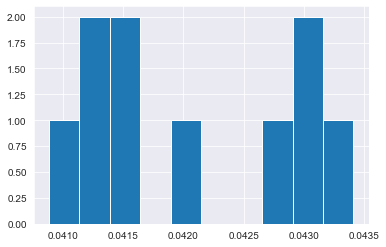

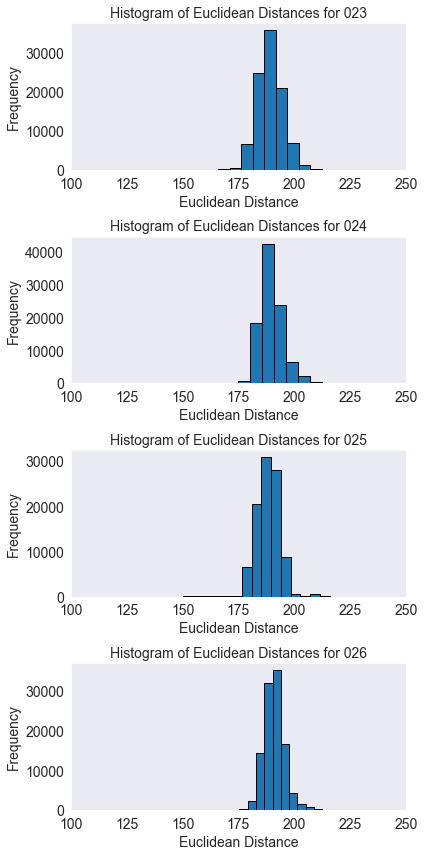

In [34]:
from scipy.stats import zscore
def plot_multiple_histograms(dataframes_dict, export_path=False):
    """
    This function takes a dictionary of DataFrames and plots a histogram of the Euclidean distances
    between caudal_edge and rostral_edge points for each DataFrame in separate subplots.
    
    :param dataframes_dict: Dictionary where keys are labels and values are DataFrames containing the 
                            columns 'caudal_edge_x', 'caudal_edge_y', 'rostral_edge_x', and 'rostral_edge_y'
    """
    # Number of dataframes
    num_dataframes = len(dataframes_dict)
    
    # Calculate the global min and max for x-axis limits
    all_distances = []
    for df in dataframes_dict.values():
        distances = np.sqrt((df['caudal_edge_x'] - df['rostral_edge_x'])**2 + 
                            (df['caudal_edge_y'] - df['rostral_edge_y'])**2)
        all_distances.extend(distances)
    all_zscore = zscore(all_distances)
    global_min = min(all_distances)
    global_max = max(all_distances)
    
    # Create subplots
    fig, axes = plt.subplots(nrows=num_dataframes, ncols=1, figsize=(6, 3 * num_dataframes), sharex=False)
    
    if num_dataframes == 1:
        axes = [axes]
    
    # Font size adjustment
    font_size = 14
    global_min = 100
    global_max = 250
    # Iterate over the dictionary and plot histograms
    for ax, (label, df) in zip(axes, dataframes_dict.items()):
        # Calculate Euclidean distances
        distances = np.sqrt((df['caudal_edge_x'] - df['rostral_edge_x'])**2 + 
                            (df['caudal_edge_y'] - df['rostral_edge_y'])**2)
        z_scores = zscore(distances)
        filtered_distances = distances[(z_scores >= -5) & (z_scores <= 5)]
        # Plot histogram
        ax.hist(filtered_distances, bins=15, edgecolor='black')
        ax.set_title(f'Histogram of Euclidean Distances for {label}', fontsize=font_size)
        ax.set_xlabel('Euclidean Distance', fontsize=font_size)
        ax.set_ylabel('Frequency', fontsize=font_size)
        ax.tick_params(axis='both', which='major', labelsize=font_size)
        ax.grid(False)  # Remove grid
        ax.set_xlim(global_min, global_max)  # Set the same x-axis limits
    
    plt.tight_layout()
    plt.show()
    if export_path is not False:
        fig.savefig(export_path,format='pdf')

import datetime
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_caudal_to_rostral_distance_histogram_right_eye.pdf'
plot_multiple_histograms(df_dict, export_path=export_path)

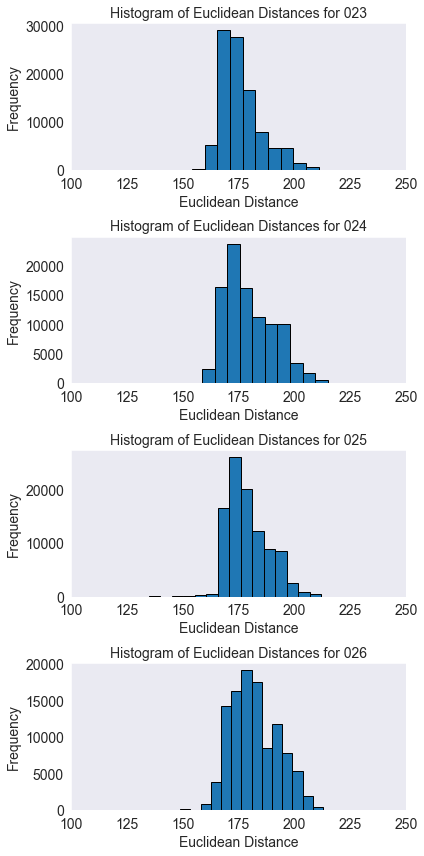

In [32]:
from scipy.stats import zscore
def plot_multiple_histograms(dataframes_dict, export_path=False):
    """
    This function takes a dictionary of DataFrames and plots a histogram of the Euclidean distances
    between caudal_edge and rostral_edge points for each DataFrame in separate subplots.
    
    :param dataframes_dict: Dictionary where keys are labels and values are DataFrames containing the 
                            columns 'caudal_edge_x', 'caudal_edge_y', 'rostral_edge_x', and 'rostral_edge_y'
    """
    # Number of dataframes
    num_dataframes = len(dataframes_dict)
    
    # Calculate the global min and max for x-axis limits
    all_distances = []
    for df in dataframes_dict.values():
        distances = np.sqrt((df['caudal_edge_x'] - df['rostral_edge_x'])**2 + 
                            (df['caudal_edge_y'] - df['rostral_edge_y'])**2)
        all_distances.extend(distances)
    all_zscore = zscore(all_distances)
    global_min = min(all_distances)
    global_max = max(all_distances)
    
    # Create subplots
    fig, axes = plt.subplots(nrows=num_dataframes, ncols=1, figsize=(6, 3 * num_dataframes), sharex=False)
    
    if num_dataframes == 1:
        axes = [axes]
    
    # Font size adjustment
    font_size = 14
    global_min = 100
    global_max = 250
    # Iterate over the dictionary and plot histograms
    for ax, (label, df) in zip(axes, dataframes_dict.items()):
        # Calculate Euclidean distances
        distances = np.sqrt((df['caudal_edge_x'] - df['rostral_edge_x'])**2 + 
                            (df['caudal_edge_y'] - df['rostral_edge_y'])**2)
        z_scores = zscore(distances)
        filtered_distances = distances[(z_scores >= -5) & (z_scores <= 5)]
        # Plot histogram
        ax.hist(filtered_distances, bins=15, edgecolor='black')
        ax.set_title(f'Histogram of Euclidean Distances for {label}', fontsize=font_size)
        ax.set_xlabel('Euclidean Distance', fontsize=font_size)
        ax.set_ylabel('Frequency', fontsize=font_size)
        ax.tick_params(axis='both', which='major', labelsize=font_size)
        ax.grid(False)  # Remove grid
        ax.set_xlim(global_min, global_max)  # Set the same x-axis limits
    
    plt.tight_layout()
    plt.show()
    if export_path is not False:
        fig.savefig(export_path,format='pdf')

import datetime
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_caudal_to_rostral_distance_histogram.pdf'
plot_multiple_histograms(df_dict, export_path=export_path)

# Automated steps (return to pipeline)

In [7]:
# getting the caudal and rostral edges testing here:
from ellipse import LsqEllipse


# find the dlc files, check for filtered results

pl = [i for i in os.listdir(block.l_e_path) if 'DLC' in i and '.csv' in i]
if len(pl) > 1:
    pl = [i for i in pl if 'filtered' in i][0]
else:
    pl = pl[0]
csv  = pd.read_csv(block.l_e_path / pl, header=1)

# # import the dataframe and convert it to floats
# data = csv
# data = data.iloc[1:].apply(pd.to_numeric)
# 
# 
# edge_elements = np.array([x for x in data.columns if 'edge' in x])
# edge_elements
ellipse_df = eye_tracking_analysis(csv,0.998)

c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 107640/107640 [01:06<00:00, 1606.89it/s]



 ellipses calculation complete


In [8]:
ellipse_df[['caudal_edge_x', 'caudal_edge_y']] = pd.DataFrame(ellipse_df['caudal_edge'].tolist(), index=ellipse_df.index)
ellipse_df[['rostral_edge_x', 'rostral_edge_y']] = pd.DataFrame(ellipse_df['rostral_edge'].tolist(), index=ellipse_df.index)
#ellipse_df.drop(columns=['caudal_edge','rostral_edge'], inplace=True)


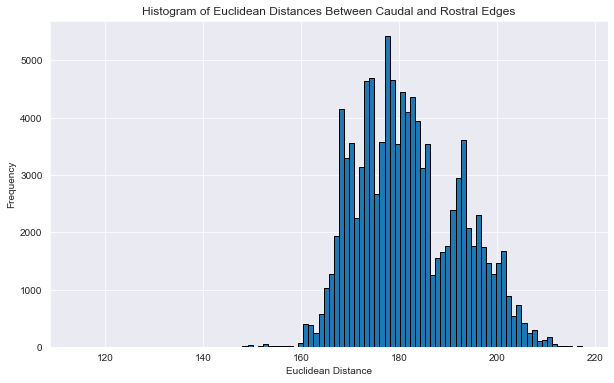

In [13]:
def plot_euclidean_distance_histogram(df):
    """
    This function calculates the Euclidean distance between caudal_edge and rostral_edge points
    for every row in the DataFrame and displays a histogram of these distances.
    
    :param df: DataFrame containing the columns 'caudal_edge_x', 'caudal_edge_y', 
               'rostral_edge_x', and 'rostral_edge_y'
    """
    # Calculate Euclidean distances
    distances = np.sqrt((df['caudal_edge_x'] - df['rostral_edge_x'])**2 + 
                        (df['caudal_edge_y'] - df['rostral_edge_y'])**2)
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(distances, bins=100, edgecolor='black')
    plt.title('Histogram of Euclidean Distances Between Caudal and Rostral Edges')
    plt.xlabel('Euclidean Distance')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
plot_euclidean_distance_histogram(ellipse_df)

In [5]:
# This step is used to quickly go over the analyzed blocks and load their internal data
for block in block_collection:
    block.handle_arena_files()
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)
    
    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()

handling arena files
Arena video Names:
back_20230427T122154.mp4
left_20230427T122154.mp4
right_20230427T122154.mp4
top_20230427T122154.mp4
top_annotated.mp4
top_annotated2.mp4
running parse_open_ephys_events...
block 026 has a parsed events file, reading...
getting eye brigtness values for block 026...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder


In [5]:
for block in block_collection:
    block.read_dlc_data(overwrite=False, export=True)
    block.calibrate_pixel_size(10)

eye dataframes loaded from analysis folder
got the calibration values from the analysis folder


# From here on, only run if right/left_eye_data is NOT in the exported files of the block 

# Jitter Correction

In [6]:
for block in block_collection:
    block.get_jitter_reports(export=True, overwrite=False, remove_led_blinks=False, sort_on_loading=True)

jitter report loaded from analysis folder
results saved to Z:\Nimrod\experiments\PV_62\2023_05_09\block_063\analysis\jitter_report_dict.pkl
Got the jitter report - check out re/le_jitter_dict attributes


In [19]:
rx_median_series = pd.Series(signal.medfilt(block.re_jitter_dict['x_displacement'], kernel_size=13),
                             name='x_correction')
ry_median_series = pd.Series(signal.medfilt(block.re_jitter_dict['y_displacement'], kernel_size=13),
                             name='y_correction')
# bokeh_plotter([block.le_jitter_dict['top_correlation_dist'],block.re_jitter_dict['top_correlation_dist']],
#               ['Left_eye','right_eye'],'check jitter report','frame', 'top_corr_dist')
bokeh_plotter([rx_median_series, ry_median_series, block.re_jitter_dict['top_correlation_dist']],
               ['x_median','y_median', 'overall_dist'],'check jitter report','frame', 'top_corr_dist')

In [7]:
for block in block_collection:
#    block.get_jitter_reports(export=True, overwrite=True, remove_led_blinks=False, sort_on_loading=True)
    block.correct_jitter()
    block.find_led_blink_frames(plot=False)
    block.remove_led_blinks_from_eye_df(export=True)

100%|██████████| 133/133 [00:00<00:00, 5212.46it/s]

center_x_corrected already exists, no need to re-run jitter correction
collecting left-eye data
data length is 199616
z_score length is 199616
collecting right eye data
data length is 199617
z_score length is 199617
removed led blink data from le / re dataframes


exported nan filled dataframes to csv


In [8]:
df_inds_to_remove_l, vid_inds_l = find_jittery_frames(block,'left',max_distance=60, diff_threshold=15, gap_to_bridge=24)
df_inds_to_remove_r, vid_inds_r = find_jittery_frames(block,'right',max_distance=60, diff_threshold=15, gap_to_bridge=24)

# These are verification plots for the jitter outlier removal functions:
# to verify, I want a bokeh explorable:
rdf = pd.DataFrame.from_dict(block.re_jitter_dict)
ldf = pd.DataFrame.from_dict(block.le_jitter_dict)

the diff based jitter frame exclusion gives: (69,)
the threshold based jitter frame exclusion gives: (84,)
the diff based jitter frame exclusion gives: (55,)
the threshold based jitter frame exclusion gives: (50,)


In [9]:
bokeh_plotter([rdf.top_correlation_dist], ['drift_distance'], peaks=vid_inds_r)

In [16]:
bokeh_plotter([ldf.top_correlation_dist], ['drift_distance'], peaks=vid_inds_l)

In [10]:
block.remove_eye_datapoints_based_on_video_frames('right', indices_to_nan=vid_inds_r)
block.remove_eye_datapoints_based_on_video_frames('left', indices_to_nan=vid_inds_l)

removed 105 from the right eye dataframe
removed 186 from the left eye dataframe


# Data rotation

In [11]:
block.rotate_data_according_to_frame_ref('left')

Please select two points on the frame.
left rotation matrix: 
 [[   0.87611802   -0.48209669  155.34543893]
 [   0.48209669    0.87611802 -124.53926471]] 
 left rotation angle: 
 -28.822429766272286
left data rotated


In [12]:
block.rotate_data_according_to_frame_ref('right')

Please select two points on the frame.
right rotation matrix: 
 [[  0.78859335   0.61491505 -79.92948591]
 [ -0.61491505   0.78859335 247.51041288]] 
 right rotation angle: 
 37.94574826663529
right data rotated


In [13]:
block.create_eye_data()

Index(['Arena_TTL', 'R_eye_frame', 'ms_axis', 'center_x_rotated',
       'center_y_rotated', 'phi_rotated', 'width', 'height', 'major_ax',
       'minor_ax', 'ratio'],
      dtype='object')
   OE_timestamp  eye_frame     ms_axis    center_x    center_y        phi  \
0    73675742.0        2.0  3683787.10  323.790127  182.617573  55.209270   
1    73676082.0        3.0  3683804.10  323.683411  182.559456  55.849070   
2    73676422.0        4.0  3683821.10  323.665079  182.643025  55.477510   
3    73676761.0        5.0  3683838.05  323.680713  182.594852  55.512638   
4    73677100.0        6.0  3683855.00  323.855380  182.675145  54.136017   

       width     height   major_ax   minor_ax     ratio  
0  47.833289  36.312965  47.833289  36.312965  1.317251  
1  47.868578  36.379557  47.868578  36.379557  1.315810  
2  47.858675  36.473646  47.858675  36.473646  1.312144  
3  47.807356  36.457424  47.807356  36.457424  1.311320  
4  47.737059  36.377713  47.737059  36.377713  1.312261  

C:\Users\MarkS3\PycharmProjects\pythonProject3\BlockSync_current.py:2511: RuntimeWarning: All-NaN axis encountered
  df['major_ax'] = np.nanmax(df[['width', 'height']], axis=1)
C:\Users\MarkS3\PycharmProjects\pythonProject3\BlockSync_current.py:2512: RuntimeWarning: All-NaN axis encountered
  df['minor_ax'] = np.nanmin(df[['width', 'height']], axis=1)


In [45]:
# This bit examine the ellipses to verify phi jump issues
block.right_eye_data['phi'] = block.right_eye_data['phi'] + 90

In [38]:
block.left_eye_data['phi'] = block.left_eye_data['phi'] + 90

In [14]:
# right eye inspection after rotation
path_to_video = [x for x in pathlib.Path(block.re_videos[0]).parent.iterdir() if '.mp4' in str(x.name) and 'DLC' in str(x.name)][0]
print(path_to_video)
play_video_with_ellipses_rotation_plus_major_axis(block=block,eye='right', path_to_video=str(path_to_video) ,xflip=True, transformation_matrix=block.right_rotation_matrix)

Z:\Nimrod\experiments\PV_62\2023_05_09\block_063\eye_videos\RE\20230509_pv62_trial4_640x480_60hz_experiment_1_recording_0\20230509_pv62_trial4DLC_resnet50_pogona_eye_trackingMay25shuffle1_1030000_filtered_labeled.mp4


In [14]:
# right eye inspection after rotation
path_to_video = [x for x in pathlib.Path(block.le_videos[0]).parent.iterdir() if '.mp4' in str(x.name) and 'DLC' in str(x.name)][0]
print(path_to_video)
play_video_with_ellipses_rotation_plus_major_axis(block=block,eye='left', path_to_video=str(path_to_video) ,xflip=True, transformation_matrix=block.left_rotation_matrix)

Z:\Nimrod\experiments\PV_62\2023_05_18\block_070\eye_videos\LE\230518_pv62_trial4_640x480_60hz_experiment_1_recording_0\230518_pv62_trial4_LEDLC_resnet50_pogona_eye_trackingMay25shuffle1_1030000_filtered_labeled_LE.mp4


In [15]:
# check that the major - minor axes are always the correct ones
sum(block.right_eye_data.dropna().major_ax > block.right_eye_data.dropna().minor_ax) == len(block.right_eye_data.dropna())
# they are, this doesn't make sense since I see jumps and switches (and my function draws the wrong axis as major on jumpy phi behavior)

True

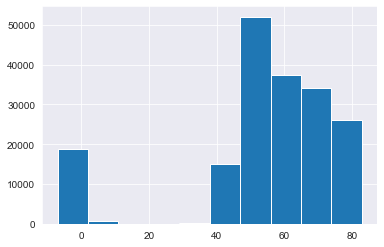

In [15]:
block.right_eye_data.phi.dropna().hist() # This shows that there are two distributions.. 90 degrees apart

In [16]:
# find where angles are jumpy
angles = block.left_eye_data.phi.values
high_diff_inds = np.where(np.abs(np.diff(angles)) > 70)[0]
len(high_diff_inds)
bokeh_plotter([angles],['angles'],peaks=high_diff_inds)

#np.diff(angles)[high_diff_inds]

In [ ]:
# correct jumpy angles???
angles[np.where(angles<100)[0]] = angles[np.where(angles<100)[0]] + 90
bokeh_plotter([angles],['angles'],peaks=high_diff_inds)

In [ ]:
# corrected phi angles for opencv conventions:


# Rotation eye data Verification

In [17]:
# right eye inspection after rotation
path_to_video = [x for x in pathlib.Path(block.re_videos[0]).parent.iterdir() if '.mp4' in str(x.name) and 'DLC' in str(x.name)][0]
print(path_to_video)
play_video_with_ellipses_rotation(block=block,eye='right', path_to_video=str(path_to_video) ,xflip=True, transformation_matrix=block.right_rotation_matrix)

Z:\Nimrod\experiments\PV_62\2023_05_09\block_063\eye_videos\RE\20230509_pv62_trial4_640x480_60hz_experiment_1_recording_0\20230509_pv62_trial4DLC_resnet50_pogona_eye_trackingMay25shuffle1_1030000_filtered_labeled.mp4


In [26]:
# left eye inspection
path_to_video = [x for x in pathlib.Path(block.le_videos[0]).parent.iterdir() if '.mp4' in str(x.name) and 'DLC' in str(x.name)][0]
play_video_with_ellipses_rotation(block=block,eye='left', path_to_video=str(path_to_video) ,xflip=True, transformation_matrix=block.left_rotation_matrix)

In [17]:
# This helps me understand what's the deal with the opencv2 ellipse phis
import numpy as np
import cv2

def draw_ellipse():
    # Create a black background image
    width, height = 500, 500
    black_bg = np.zeros((height, width, 3), dtype=np.uint8)

    # Define ellipse parameters
    center = (250, 250)
    axes_lengths = (100, 50)
    angle = 10  # Rotation angle in degrees
    start_angle = 90
    end_angle = 360
    color = (0, 255, 0)  # Green color in BGR format
    thickness = 2

    # Draw ellipse on the black background
    cv2.ellipse(black_bg, center, axes_lengths, angle, start_angle, end_angle, color, thickness)

    # Display the image
    cv2.imshow('Ellipse', black_bg)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Call the function to draw the ellipse
draw_ellipse()


# Eye videos relative lag correction

In [19]:
# block integrated version:
block.find_led_blink_frames()
l_df, r_df = block.correct_relative_eye_drift_based_on_LED_lights_out(verification_plots=False)
block.left_eye_data = l_df
block.right_eye_data = r_df

100%|██████████| 133/133 [00:00<00:00, 5314.05it/s]

collecting left-eye data
data length is 199616
z_score length is 199616
collecting right eye data
data length is 199617
z_score length is 199617
missing frame at 2
missing frame at 6
missing frame at 8


195308 195308
0
5
0 S
1 S
2 S
3 L
[16717     1]
4 S
5 S
6 L
[34403     1]
7 S
8 S
9 S
10 L
[48552     1]
11 S
12 S
13 L
[59165     1]
14 S
15 L
[66241     1]
16 S
17 S
18 S
19 S
20 S
21 S
22 S
23 S
24 S
25 S
26 S
27 S
28 S
29 S
30 S
31 S
32 S
33 S
34 S
35 S
36 S
37 S
38 S
39 S
40 S
41 S
42 S
43 S
44 S
45 S
46 S
47 S
48 S
49 S
50 S
51 S


C:\Users\MarkS3\PycharmProjects\pythonProject3\BlockSync_current.py:2262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ms_axis'].iloc[ind_to_remove:] = original_ms_axis[:-1]
C:\Users\MarkS3\PycharmProjects\pythonProject3\BlockSync_current.py:2264: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OE_timestamp'].iloc[ind_to_remove:] = original_oe_axis[:-1]


In [20]:
l_df, r_df = block.correct_eye_sync_based_on_OE_LED_events()

missing frame at 2
missing frame at 6
double row at 7
missing frame at 8
double row at 11
double row at 18
double row at 45
The correction employed was 102563.0, 
check the output and overwirte the left/right eye data dfs when happy, then re-export


In [22]:
block.left_eye_data = l_df
block.right_eye_data = r_df

In [45]:
# I get weird behavior from my OE_LED sync - here is where I'm testing what's really up
# helper functrions:
def find_middle_values(series):
    # Create a DataFrame from the series
    data = pd.DataFrame({'index': series.index, 'value': series.values})

    # Identify chunks of consecutive indices
    data['chunk'] = (data['index'].diff() != 1).cumsum()

    # Function to get the middle value of each chunk
    def get_middle_value(chunk):
        # Calculate the position of the middle value (0-based index)
        middle_idx = (len(chunk) - 1) // 2
        return chunk.iloc[middle_idx]['value']

    # Group by chunk and apply the function to find the middle value
    middle_values = data.groupby('chunk').apply(get_middle_value).tolist()

    return middle_values

oe_led_blinks = block.oe_events[['LED_driver']].query('LED_driver == LED_driver').values
ms_timestamps = oe_led_blinks.T / 20
ms_axis = block.left_eye_data.ms_axis.values
ms_blink_frames = []
# The timestamps now correspond with the real time axis and not the down-sampled arena frames time markers -
# the following code corrects that and finds the closest frames
for t in ms_timestamps[0]:
    ms_blink_frames.append(ms_axis[np.argmin(np.abs(ms_axis - t))])

ms_blink_times = np.array(ms_blink_frames)
le_frame_blinks = block.left_eye_data[block.left_eye_data.eye_frame.isin(block.led_blink_frames_l)].ms_axis
le_blinks_ms = find_middle_values(le_frame_blinks)
re_frame_blinks = block.right_eye_data[block.right_eye_data.eye_frame.isin(block.led_blink_frames_r)].ms_axis
re_blinks_ms = find_middle_values(re_frame_blinks)


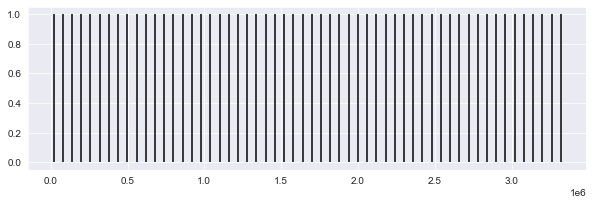

In [89]:
fig, axs = plt.subplots(figsize=(10,3))
#axs.set_xlim(ms_blink_times[5], ms_blink_times[8])
axs.vlines(ms_timestamps,ymin=0,ymax=1)
#axs.vlines(re_blinks_ms,ymin=0,ymax=1.1, color='red')
#axs.vlines(le_blinks_ms,ymin=0,ymax=1.2, color='blue')

# End of Synchronization Pipeline

In [95]:
block.oe_events[['LED_driver']].dropna().iloc[-1] / 20


LED_driver    3320400.0
Name: 1180608, dtype: float64

In [57]:
ms_timestamps = oe_led_blinks / 20
ms_blink_times = ms_timestamps

In [19]:
# load the data of an already synced block:
def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0)
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0)
        print(f'block {block.block_num} loaded')
    except FileNotFoundError:
        print(f'block {block.block_num} eye_data files not found, run the pipeline!')
        return
    
    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')
load_eye_data_2d_w_rotation_matrix(block)

block 057 loaded


# Data export steps:

In [21]:
def export_eye_data_2d_w_rotation_matrix(block):
    """
    This function saves the eye dataframes to two csv files
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    block.right_eye_data.to_csv(block.analysis_path / 'right_eye_data.csv')
    block.left_eye_data.to_csv(block.analysis_path / 'left_eye_data.csv')
    rotation_dict = {'left_rotation_matrix': block.left_rotation_matrix,
                'left_rotation_angle':  block.left_rotation_angle,
                'right_rotation_matrix':block.right_rotation_matrix,
                'right_rotation_angle': block.right_rotation_angle}
    with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'wb') as file:
        pickle.dump(rotation_dict, file)
        print(f'eye dataframes and rotation matrix saved to: {file}')
        
export_eye_data_2d_w_rotation_matrix(block)

eye dataframes and rotation matrix saved to: <_io.BufferedWriter name='Z:\\Nimrod\\experiments\\PV_62\\2023_05_09\\block_063\\analysis\\rotate_eye_data_params.pkl'>


In [ ]:
# This checks which blocks have eye data:
for block in block_collection:
    load_eye_data_2d_w_rotation_matrix(block)
    
    

In [108]:
block.eye_tracking_analysis()

BlockSync object for animal PV_62 with 
block_num 063 at date 2023-05-09_14-01-20

In [41]:
def get_angles_new(block,eye,
               models_path,
               models_names=['model_phi_xgb','model_theta_xgb','scaler_xgb'],
               column_prefix=''):
    """
    This function translate 2d ellipse data to phi and theta angles
    :df: dataframe with ellipse data. must contain the columns - center_x, center_y, ellipse_phi, ratio
    :models_path: directory with two regression models (for phi and theta) and a scaler for standardization
    :models_names: optional, list of models' names in the following order - phi,theta,scaler
    :column_prefix: optional, prefix for the added columns' names (useful for saving multiple models results)
    :return: input df with two additional columns of predicted phi and theta angles
    """
    model_phi = pickle.load(open(str(models_path / (models_names[0] + '.sav')), 'rb'))
    model_theta = pickle.load(open(str(models_path / (models_names[1] + '.sav')), 'rb'))
    scaler = pickle.load(open(str(models_path / (models_names[2] + '.sav')), 'rb'))
    if eye == 'left':
        df = block.left_eye_data
        dx = block.left_eye_reference_xy[0]
        dy = block.left_eye_reference_xy[1]
    elif eye == 'right':
        df = block.right_eye_data
        dx = block.right_eye_reference_xy[0]
        dy = block.right_eye_reference_xy[1]
    else:
        print('only accepted eye v')
    df_tmp = df[['center_x','center_y','ellipse_phi','ratio']]
    df_tmp['center_x'] = df['center_x'] - dx
    df_tmp['center_y'] = df['center_y'] - dy
    df_tmp = df_tmp.dropna()
    x = scaler.transform(df_tmp)
    pred_phi = model_phi.predict(x)
    pred_theta = model_theta.predict(x)
    df['xgb_theta'] = np.nan
    df['xgb_phi'] = np.nan
    n = len(df_tmp)
    for i in tqdm.tqdm(range(n)):
        idx = df_tmp.index[i]
        df.loc[idx,column_prefix+'phi'] = pred_phi[i]
        df.loc[idx,column_prefix+'theta'] = pred_theta[i]
    return df

In [ ]:
models_path = pathlib.Path(r'Z:\Tali\models')
models_names=['model_phi_xgb','model_theta_xgb','scaler_xgb']
model_phi = pickle.load(open(str(models_path / (models_names[0] + '.sav')), 'rb'))
model_theta = pickle.load(open(str(models_path / (models_names[1] + '.sav')), 'rb'))
scaler = pickle.load(open(str(models_path / (models_names[2] + '.sav')), 'rb'))
df = block.right_eye_data
df_tmp = df[['center_x','center_y','ellipse_phi','ratio']]
# s = df.major_ax / df.minor_ax
# idx = np.argmin(np.abs(s - 1))  # find the index of the value closest to 1
# dx = df.loc[idx,'center_x']
# dy = df.loc[idx,'center_y']
dx = block.left_eye_reference_xy[0]
dy = block.left_eye_reference_xy[1]
df_tmp['center_x'] = df['center_x'] - dx
df_tmp['center_y'] = df['center_y'] - dy
df_tmp = df_tmp.dropna()
df_tmp

In [ ]:
df_tmp = block.left_eye_data[['center_x','center_y','ellipse_phi','ratio']]
s = df.major_ax / df.minor_ax
idx = np.argmin(np.abs(s - 1))  # find the index of the value closest to 1
dx = block.left_eye_reference_xy[0]
dy = block.left_eye_reference_xy[1]


In [ ]:
# integrate the steps below to a rolling pipeline:
for block in block_collection:
    # get major and minor columns:
    block.left_eye_data = block.get_maj_min_axes(block.left_eye_data)
    block.right_eye_data = block.get_maj_min_axes(block.right_eye_data)
        

  0%|          | 0/1 [00:00<?, ?it/s]

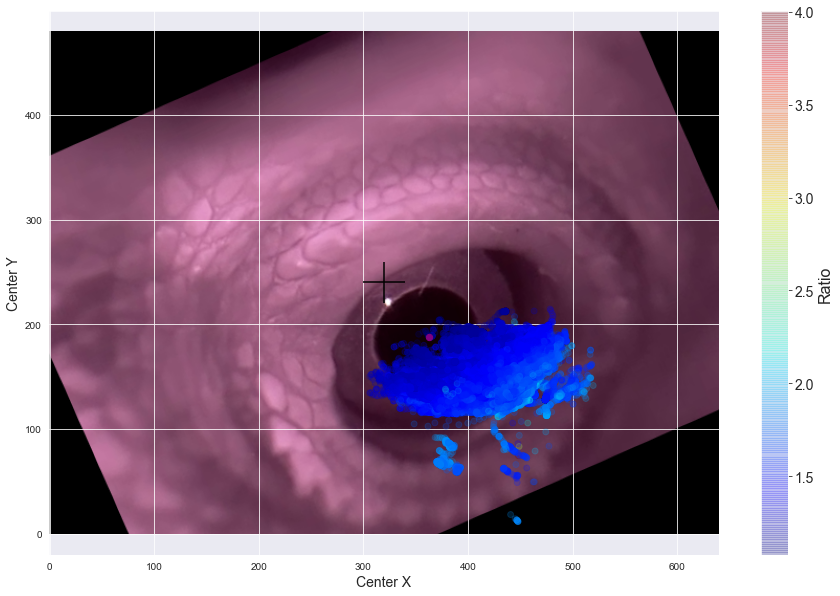

The reference point returned for this video is: X = 362.94487971847633, Y = 188.21564581084428


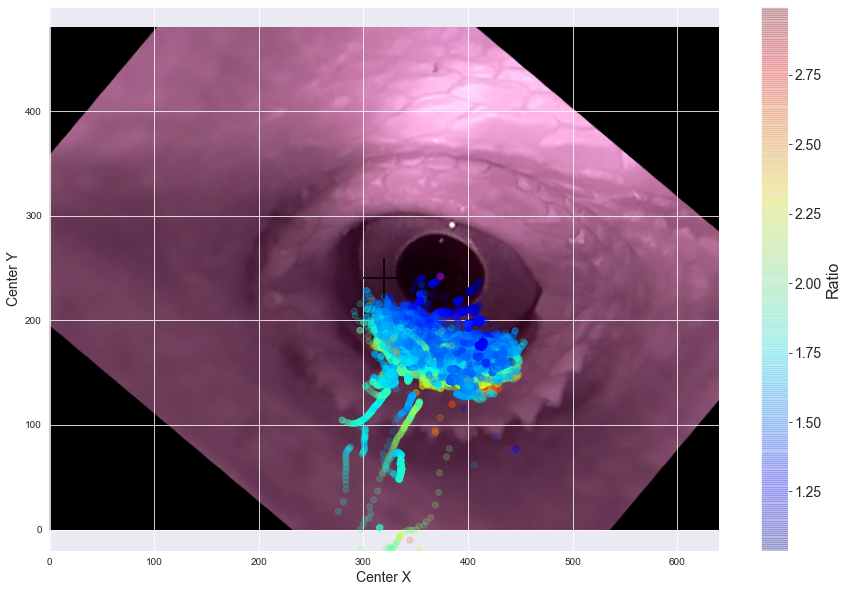

100%|██████████| 1/1 [00:07<00:00,  7.32s/it]

The reference point returned for this video is: X = 373.43264187393146, Y = 242.61319768840542


In [42]:
for block in tqdm.tqdm(block_collection):
    # 1. get reference xy points for both eyes:
    block.left_eye_reference_xy = block.get_best_reference('left')
    block.right_eye_reference_xy = block.get_best_reference('right')


In [43]:
for block in block_collection:
    # rename the ellipse phi column to make room for phi
    if 'ellipse_phi' not in block.right_eye_data.columns:
        print('hi', block)
        block.left_eye_data = block.left_eye_data.rename(columns={'phi':'ellipse_phi'})
        block.right_eye_data = block.right_eye_data.rename(columns={'phi':'ellipse_phi'})

    


hi PV_62, block 057, on 2023-05-08_12-17-49


In [44]:
path_to_models = pathlib.Path(r'Z:\Tali\models')
for block in block_collection:
    print(f'working on {block}')
    if 'theta' not in block.right_eye_data.columns:
        print('needs angle calculations')
        # run the get_angles function
        l_df = get_angles_new(block, 'left', path_to_models)
        r_df = get_angles_new(block, 'right', path_to_models)
        # 4. get pupil diameter according to major axis
        l_df['pupil_diameter_pixels'] = l_df.major_ax * 2 * np.pi
        r_df['pupil_diameter_pixels'] = r_df.major_ax * 2 * np.pi
        l_df['pupil_diameter'] = l_df['pupil_diameter_pixels'] * block.L_pix_size
        r_df['pupil_diameter'] = r_df['pupil_diameter_pixels'] * block.R_pix_size
        
        # 5. reset the r/l dfs as eye_data
        block.left_eye_data = l_df
        block.right_eye_data = r_df

working on PV_62, block 057, on 2023-05-08_12-17-49
needs angle calculations


C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
<ipython-input-41-68023d14c51f>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['center_x'] = df['center_x'] - dx
<ipython-input-41-68023d14c51f>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['center_y']

In [45]:
for block in block_collection:
    if 'theta' in block.right_eye_data.columns:
        print(block,'is ready for export')
        # finish by exporting the block eye data after additions:
        export_eye_data_2d_w_rotation_matrix(block)
        print(f'export of block {block.block_num} successful')
    

PV_62, block 057, on 2023-05-08_12-17-49 is ready for export
eye dataframes and rotation matrix saved to: <_io.BufferedWriter name='Z:\\Nimrod\\experiments\\PV_62\\2023_05_08\\block_057\\analysis\\rotate_eye_data_params.pkl'>
export of block 057 successful


In [ ]:
# now get all that's neccessary for the angle calculations:
# 1. define the reference points for each eye (that is, the points at which the eye ellipse looks like a circle)
block.left_eye_reference_xy = block.get_best_reference('left')
block.right_eye_reference_xy = block.get_best_reference('right')


In [ ]:
# 2. initialize model used by location:
def get_angles(df,
               models_path,
               models_names=['model_phi_xgb','model_theta_xgb','scaler_xgb'],
               column_prefix=''):
    """
    This function translate 2d ellipse data to phi and theta angles
    :df: dataframe with ellipse data. must contain the columns - center_x, center_y, ellipse_phi, axes_ratio
    :models_path: directory with two regression models (for phi and theta) and a scaler for standardization
    :models_names: optional, list of models' names in the following order - phi,theta,scaler
    :column_prefix: optional, prefix for the added columns' names (useful for saving multiple models results)
    :return: input df with two additional columns of predicted phi and theta angles
    """
    model_phi = pickle.load(open(str(models_path / (models_names[0] + '.sav')), 'rb'))
    model_theta = pickle.load(open(str(models_path / (models_names[1] + '.sav')), 'rb'))
    scaler = pickle.load(open(str(models_path / (models_names[2] + '.sav')), 'rb'))
    df_tmp = df[['center_x','center_y','ellipse_phi','ratio']]
    s = df.major_ax / df.minor_ax
    idx = np.argmin(np.abs(s - 1))  # find the index of the value closest to 1
    dx = df.loc[idx,'center_x']
    dy = df.loc[idx,'center_y']
    df_tmp['center_x'] = df['center_x'] - dx
    df_tmp['center_y'] = df['center_y'] - dy
    df_tmp = df_tmp.dropna()
    x = scaler.transform(df_tmp)
    pred_phi = model_phi.predict(x)
    pred_theta = model_theta.predict(x)
    df['xgb_theta'] = np.nan
    df['xgb_phi'] = np.nan
    n = len(df_tmp)
    for i in tqdm.tqdm(range(n)):
        idx = df_tmp.index[i]
        df.loc[idx,column_prefix+'phi'] = pred_phi[i]
        df.loc[idx,column_prefix+'theta'] = pred_theta[i]
    return df
# 3. use the model to get the phi / theta angles
block.left_eye_data = block.left_eye_data.rename(columns={'phi':'ellipse_phi'})
block.right_eye_data = block.right_eye_data.rename(columns={'phi':'ellipse_phi'})
path_to_models = pathlib.Path(r'Z:\Tali\models')

l_df = get_angles(block.left_eye_data, path_to_models)
r_df = get_angles(block.right_eye_data, path_to_models)

# 4. get pupil diameter according to major axis
l_df['pupil_diameter_pixels'] = l_df.major_ax * 2 * np.pi
r_df['pupil_diameter_pixels'] = r_df.major_ax * 2 * np.pi
l_df['pupil_diameter'] = l_df['pupil_diameter_pixels'] * block.L_pix_size
r_df['pupil_diameter'] = r_df['pupil_diameter_pixels'] * block.R_pix_size



In [ ]:
# export step:
block.left_eye_data = l_df
block.right_eye_data = r_df
export_eye_data_2d_w_rotation_matrix(block)

In [ ]:
bokeh_plotter([block.right_eye_data.pupil_diameter,block.left_eye_data.pupil_diameter],
              ['Right eye pupil','left_eye_pupil'])

In [ ]:
# 4. get pupil diameter according to major axis

bokeh_plotter([zscore_with_nan(l_df['pupil_diameter']*block.L_pix_size), zscore_with_nan(block.le_df['ellipse_size'])],['pupil_diameter','ellipse_size']) 


In [ ]:
def zscore_with_nan(data):
    # Compute mean and standard deviation excluding NaN values
    mean = np.nanmean(data)
    std = np.nanstd(data)

    # Z-score the dataset, replacing NaN values with NaN
    zscored_data = (data - mean) / std

    return zscored_data

In [ ]:
l_df['pupil_diameter_pixels'] = l_df.major_ax * 2 * np.pi
r_df['pupil_diameter_pixels'] = r_df.major_ax * 2 * np.pi
l_df['pupil_diameter'] = l_df['pupil_diameter_pixels'] * block.L_pix_size
r_df['pupil_diameter'] = r_df['pupil_diameter_pixels'] * block.R_pix_size

# playing around with a single block to understand maj/min axis behavior

In [ ]:
# get background image of roundest ellipse:
def get_maj_min_axes(df):
    def find_maj_min(row):
        major_ax = np.nanmax([row['width'], row['height']])
        minor_ax = np.nanmin([row['width'], row['height']])
        return pd.Series({'major_ax': major_ax, 'minor_ax': minor_ax})  
    
    # Apply the function and create a DataFrame
    result_df = df.apply(lambda row: find_maj_min(row), axis=1)

    # Assign the result to the original DataFrame
    df[['major_ax', 'minor_ax']] = result_df
    # define the axes ratio of the ellipse as major/minor
    df['ratio'] = df['major_ax'] / df['minor_ax']
    return df, result_df

def get_frame(frame_number, path_to_video):
    xflip=True
    # Read the video file
    cap = cv2.VideoCapture(path_to_video)
    
    # Check if the video file is opened successfully
    if not cap.isOpened():
        print("Error: Unable to open video file.")
    
    # Set the frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    # Read the frame
    ret, frame = cap.read()
    
    # Check if the frame is read successfully
    if not ret:
        print(f"Error: Unable to read frame {frame_number}.")
        cap.release()
    if xflip:
        frame = cv2.flip(frame, 1)
    
    return frame
def get_rotated_frame(block, frame_number, eye, xflip=True):
    """
    This is a method to get a rotated version of the frame for plotting and verification purpuses
    :param frame_number:
    :param eye:
    :return:
    """
    if eye == 'left':
        path_to_video = block.le_videos[0]
        rotation_matrix = block.left_rotation_matrix
    elif eye == 'right':
        path_to_video = block.re_videos[0]
        rotation_matrix = block.right_rotation_matrix
    else:
        print('eye can only be left or right')
        return

    # Read the video file
    cap = cv2.VideoCapture(path_to_video)

    # Check if the video file is opened successfully
    if not cap.isOpened():
        print("Error: Unable to open video file.")
        return None

    # Set the frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    ret, frame = cap.read()

    # Check if the frame is read successfully
    if not ret:
        print(f"Error: Unable to read frame {frame_number}.")
        cap.release()
        return None

    # horizontally flip frame if applicable:
    if xflip:
        frame = cv2.flip(frame, 1)

    rotated_frame = cv2.warpAffine(frame, rotation_matrix, (frame.shape[1], frame.shape[0]))
    return rotated_frame

block.left_eye_data, result_df = get_maj_min_axes(block.left_eye_data)
#block.right_eye_data = get_maj_min_axes(block.right_eye_data)




In [ ]:
block.define_best_reference('right')

In [ ]:

df = block.right_eye_data
s = df.major_ax / df.minor_ax
anchor_ind = np.argmin(np.abs(s - 1))  # find the index of the value closest to 1
roundest_frame_num = df['eye_frame'].iloc[anchor_ind]
frame = get_rotated_frame(block, roundest_frame_num, 'right')
minimal_ratio = df.iloc[anchor_ind].ratio


In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(15,10))
axs.imshow(frame, origin='lower', cmap='gray')
#axs.axis('equal')
#axs[1].imshow(corrected_frame, origin='lower', cmap='gray')
#axs[2].imshow(roundest_frame,origin='lower',cmap='gray')


In [ ]:
# plot with scatter for best reference verification:
fig, axs = plt.subplots(1,1,figsize=(15,10))

# Scatter plot with points colored by the 'ratio' column
sc = axs.scatter(df.center_x, df.center_y, c=df.ratio, cmap='jet', alpha=0.2)
axs.scatter(df.center_x.iloc[anchor_ind],df.center_y.iloc[anchor_ind], c='purple', alpha=1, s=40)

# Add color bar to the plot with enlarged font size
cbar = plt.colorbar(sc, ax=axs)
cbar.ax.tick_params(labelsize=14)  # Adjust font size of tick labels
cbar.set_label('Ratio', fontsize=16)  # Adjust font size of color bar label

# Adjust font size of axis labels
axs.set_xlabel('Center X', fontsize=14)
axs.set_ylabel('Center Y', fontsize=14)
axs.vlines(320,240-20,240+20)
axs.hlines(240,320-20,320+20)
axs.axis('equal')
axs.imshow(frame, origin='lower', cmap='gray')
plt.show()

In [ ]:
import cv2
import numpy as np

# Function to handle mouse events
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print("Clicked at (x={}, y={})".format(x, y))
        # Add your custom logic here for handling the mouse click

# Create a window and set mouse callback
cv2.namedWindow('Image')
cv2.setMouseCallback('Image', mouse_callback)

# Define your data (replace with your data)
# For demonstration purposes, I'll generate random data

center_x = df.dropna().center_x.astype(int)
center_y = df.dropna().center_y.astype(int)
ratio = df.dropna().ratio  # Random ratio values between 0 and 1

# Draw scatter points on the image
for x, y, r in zip(center_x, center_y, ratio):
    color = (0, int(r * 255), int((1 - r) * 255))  # Adjust color based on ratio
    cv2.circle(frame, (x, y), 5, color, -1)  # Draw a filled circle

# Display the image
cv2.imshow('Image', frame)

# Wait for any key to be pressed
cv2.waitKey(0)

# Close all OpenCV windows
cv2.destroyAllWindows()


In [ ]:
df = block.left_eye_data
s = df.width / df.height
closest_ind = np.argmin(np.abs(s - 1))  # find the index of the value closest to 1
roundest_frame_num = df['eye_frame'].iloc[closest_ind]
print(roundest_frame_num)

# Sync paradigm analysis - how much did I move the frames around?

In [ ]:
def analyze_frame_corrections(frames):
    duplicate_indices = []
    jump_indices = []
    jump_count = 0
    duplicate_count = 0
    interval_size = 3600

    for i in range(1, len(frames)):
        if frames[i] == frames[i - 1] and i not in duplicate_indices:
            duplicate_indices.append(i)
            duplicate_count += 1
        elif frames[i] != frames[i - 1] + 1 and i not in jump_indices:
            jump_indices.append(i)
            jump_count += 1

    # Collect jump distances and duplication amounts
    jump_distances = [frames[j] - frames[j - 1] for j in jump_indices]
    duplication_amounts = [frames[d] - frames[d - 1] + 1 for d in duplicate_indices]

    # Quantify occurrences within each 3600 frames
    occurrences_within_interval = len(frames) // interval_size
    duplicate_rate = duplicate_count / occurrences_within_interval
    jump_rate = jump_count / occurrences_within_interval

    report = {
        'duplicate_indices': duplicate_indices,
        'jump_indices': jump_indices,
        'jump_distances': jump_distances,
        'duplication_amounts': duplication_amounts,
        'duplicate_count': duplicate_count,
        'jump_count': jump_count,
        'occurrences_within_interval': occurrences_within_interval,
        'duplicate_rate': duplicate_rate,
        'jump_rate': jump_rate
    }

    return report
def remove_data_from_df_rows(df,indices_to_nan):
    columns_to_nan = ['center_x',
                  'center_y',
                  'phi',
                  'width',
                  'height']
    col_inds = [df.columns.get_loc(col_name) for col_name in columns_to_nan]
    df.iloc[indices_to_nan, col_inds] = np.nan
    return df


def clean_duplicated_frames_data(df, result):
    duplicated = np.insert(np.diff(result['duplicate_indices']) == 1,0,False)
    duplicated_shift = np.roll(duplicated, 1)
    dup_on_off = duplicated.astype(int) - duplicated_shift.astype(int)
    rising_edge = np.where(dup_on_off == 1)[0]
    falling_edge = np.where(dup_on_off == -1)[0]
    length_of_chunk = falling_edge - rising_edge
    duplication_on_off = np.column_stack((rising_edge,falling_edge, length_of_chunk))
    
    events_to_nan = np.where(duplication_on_off[:,2] > 8)[0] # this is the conditional where chunks threshold is defined
    start_nan = np.array(result['duplicate_indices'])[duplication_on_off[events_to_nan][:,0]]
    end_nan = np.array(result['duplicate_indices'])[duplication_on_off[events_to_nan][:,1]]
    for nan_segment in zip(start_nan,end_nan):
        rows = list(range(nan_segment[0],nan_segment[1]))
        df = remove_data_from_df_rows(df, rows)
    return df 



In [ ]:
# employ on right eye:
frame_list_r = block.right_eye_data.eye_frame.values
result_r = analyze_frame_corrections(frame_list_r)

#print("Duplicate Indices:", len(result['duplicate_indices']))
#print("Jump Indices:", len(result['jump_indices']))
print('right eye report:')
print(f'overall length of video:{len(frame_list_r)} = {len(frame_list_r) // 60 //60} minutes')
print("Duplicate Count:", result_r['duplicate_count'])
print("Jump Count:", result_r['jump_count'])
print(f"overall correction percentage: {((result_r['duplicate_count'] + result_r['jump_count']) / len(frame_list_r)) * 100}")
print("Occurrences within 3600 frames:", result_r['occurrences_within_interval'])
print("Duplicate Frames per-minute:", np.round(result_r['duplicate_rate']))
print("Jump frames per-minute:", np.round(result_r['jump_rate']))

# employ on left eye:
frame_list_l = block.left_eye_data.eye_frame.values
result_l = analyze_frame_corrections(frame_list_l)

#print("Duplicate Indices:", len(result['duplicate_indices']))
#print("Jump Indices:", len(result['jump_indices']))
print('left eye report:')
print(f'overall length of video:{len(frame_list_l)} = {len(frame_list_l) // 60 //60} minutes')
print("Duplicate Count:", result_l['duplicate_count'])
print("Jump Count:", result_l['jump_count'])
print(f"overall correction percentage: {((result_l['duplicate_count'] + result_l['jump_count']) / len(frame_list_l)) * 100}")
print("Occurrences within 3600 frames:", result_l['occurrences_within_interval'])
print("Duplicate Frames per-minute:", np.round(result_l['duplicate_rate']))
print("Jump frames per-minute:", np.round(result_l['jump_rate']))

In [ ]:
r_df = clean_duplicated_frames_data(block.right_eye_data,result_r)
l_df = clean_duplicated_frames_data(block.left_eye_data,result_l)


In [ ]:
# this cell identifies segments where many duplications occur and NaNs the data from these points:
r_df_framesort = r_df.dropna()
plt.plot(np.diff(r_df_framesort.OE_timestamp.values[:]))

In [ ]:
# stupid cell for inspection of duplicate dispersion
fig,axs = plt.subplots(figsize=(17,5),dpi=150)
axs.vlines(result_r['jump_indices'],0,0.1,color='r',linestyles='-',linewidth=0.5)
#axs.vlines(result_r['duplicate_indices'],0,0.1,color='b',linestyles='-', linewidth=0.5)
xlim = np.array([0,3600]) + 3600*1
axs.set_xlim(xlim[0],xlim[1])
#axs.set_xlim(29800,29850)

In [ ]:
# This section looks at the RPI report csvs
rpi_df = pd.read_csv([ l for l in pathlib.Path(block.le_videos[0]).parent.iterdir() if 'timestamps.csv' in str(l)][0])

In [ ]:
rpi_df['diff'] = rpi_df['# frame timestamp'] - rpi_df[' TTL timestamp']
plt.plot(np.diff(rpi_df[' TTL timestamp'].values))

# The following is the preliminary version of the OE LED blink synchronization
before incorporation into the class

In [ ]:
def duplicate_df_row_at_index(df, ind_to_duplicate, correct_ms=True, correct_oe_timestamps=True):
    """
    :param correct_ms: if true, will correct the ms_axis of eye data
    :param df: dataframe 
    :param ind_to_duplicate: which row to duplicate, in iloc logic
    :return: longer df 
    """
    # cut the df
    df_top = df.iloc[:ind_to_duplicate]
    df_bot = df.iloc[ind_to_duplicate:]
    # duplicate the row
    df_top = df_top.append(df_top.iloc[-1])
    df_longer = pd.concat([df_top, df_bot], ignore_index=False)
    if correct_ms:
        df_longer['ms_axis'].iloc[ind_to_duplicate:-1] = df_longer['ms_axis'].iloc[ind_to_duplicate+1:].values
    if correct_oe_timestamps:
        df_longer['OE_timestamp'].iloc[ind_to_duplicate:-1] = df_longer['OE_timestamp'].iloc[ind_to_duplicate+1:].values
    return df_longer.copy()

def remove_df_row_at_index(df, ind_to_remove, correct_ms=True, correct_oe_timestamps=True):
    label_to_remove = df.index[ind_to_remove]
    original_ms_axis = df['ms_axis'].iloc[ind_to_remove:].values
    original_oe_axis = df['OE_timestamp'].iloc[ind_to_remove:].values
    df = df.drop(label_to_remove)
    if correct_ms:
        df['ms_axis'].iloc[ind_to_remove:] = original_ms_axis[:-1]
    if correct_oe_timestamps:
        df['OE_timestamp'].iloc[ind_to_remove:] = original_oe_axis[:-1]
    return df

def correct_relative_eye_drift_based_on_LED_lights_out(block, verification_plots=True):
    r_vals = block.re_frame_val_list[0][1]
    l_vals = block.le_frame_val_list[0][1]
    l_blinks = block.led_blink_frames_l
    r_blinks = block.led_blink_frames_r
    chunks_r = np.insert(np.diff(r_blinks) > 10,0,False)
    r_inds = np.insert(r_blinks[chunks_r],0,r_blinks[0])
    chunks_l = np.insert(np.diff(l_blinks) > 10,0,False)
    l_inds = np.insert(l_blinks[chunks_l],0,l_blinks[0])
    # check for non-matchig lengths
    if len(l_inds) > len(r_inds):
        if max(l_inds) > max(r_inds) + 100: # left with an extra led at the end
            l_inds = l_inds[:len(r_inds)]
        elif min(l_inds) < min(r_inds) - 100: # left with extra led at the beginning
            l_inds = l_inds[1:]
    elif len(r_inds) > len(l_inds):
        if max(r_inds) > max(l_inds) + 100:
            r_inds = r_inds[:len(l_inds)]
        elif min(r_inds) < min(l_inds) - 100:
            r_inds = r_inds[1:]
        
    if verification_plots:
        # verify detection here:
        z_score_data_r = block.rolling_window_z_scores(r_vals, roll_w_size=1500)
        z_score_data_l = block.rolling_window_z_scores(l_vals, roll_w_size=1500)
        
        bokeh_plotter([z_score_data_r, z_score_data_l],
                      label_list=['r_scores', 'l_scores'],
                      x_axis='Frame',
                      y_axis='brightness Z score', 
                      peaks=[r_inds, l_inds], peaks_list=True)
    # I want to understand the drift between the two corrected l_ms vectors now - if a frame appears in two l_ms values, take the larger one (a duplicated frame)
    l_frames = []
    r_frames = []
    l_ms = []
    r_ms = []
    l_blink_inds = []
    r_blink_inds = []
    # collect the l_ms list
    for i, (lb,rb) in enumerate(zip(l_inds,r_inds)):
        l_blink_row = block.left_eye_data.query('eye_frame == @lb')
        r_blink_row = block.right_eye_data.query('eye_frame == @rb')
        #check that both rows exist in the eye dataframes
        if r_blink_row.empty or l_blink_row.empty:
            print('missing frame at',i)
            continue
        l_blink_row = l_blink_row.iloc[-1][['eye_frame', 'ms_axis']]
        l_ms.append(l_blink_row['ms_axis'])
        l_frames.append(l_blink_row['eye_frame'])
        l_blink_inds.append(l_blink_row.name)
        r_blink_row = r_blink_row.iloc[-1][['eye_frame', 'ms_axis']]
        r_ms.append(r_blink_row['ms_axis'])
        r_frames.append(r_blink_row['eye_frame'])
        r_blink_inds.append(r_blink_row.name)
    # This bit creates a map of the neccessary movements to each dataframe in order for the sync to match (for each blink)
    r_arr = np.array([r_frames, r_ms]).T
    l_arr = np.array([l_frames, l_ms]).T
    diff_arr = r_arr[:,1] - l_arr[:,1]
    diff_arr = (diff_arr // 17).astype(int)
    correction_order = []
    l_corrections_inds = []
    l_corrections_size = []
    r_corrections_inds = []
    r_corrections_size = []
    stable_ind_pairs = []
    for i, diff in enumerate(diff_arr):
        if diff > 0: # L lagging
            l_corrections_inds.append(l_blink_inds[i])
            l_corrections_size.append(diff)
            correction_order.append('L')
        elif diff < 0: # R lagging
            r_corrections_inds.append(r_blink_inds[i])
            r_corrections_size.append(np.abs(diff))
            correction_order.append('R')
        else:
            stable_ind_pairs.append([r_blink_inds[i], l_blink_inds[i]])
            correction_order.append('S')
    r_corrections = np.array([r_corrections_inds, r_corrections_size]).T
    l_corrections = np.array([l_corrections_inds, l_corrections_size]).T

    
    # This is the second try:
    l_df = block.left_eye_data.copy()
    r_df = block.right_eye_data.copy()
    print(len(l_df),len(r_df))
    current_l_correction = 0
    current_r_correction = 0
    print(len(r_corrections))
    print(len(l_corrections))
    # Initialize lists to track inserted rows
    inserted_rows_l = []
    removed_rows_l = []
    inserted_rows_r = []
    removed_rows_r = []
    for minute, df_to_correct in enumerate(correction_order):
        print(minute, df_to_correct)
        if df_to_correct == 'L':
            l_corr = l_corrections[current_l_correction]
            inserted_rows_l.append(l_corr)
            print(l_corr)
            for row in range(l_corr[1]):
                l_df = duplicate_df_row_at_index(l_df,l_corr[0], correct_ms=True, correct_oe_timestamps=True)
                inserted_rows_l.append(l_corr[0])
                try:
                    l_df = remove_df_row_at_index(l_df, l_corr[0] + 3534, correct_ms=True, correct_oe_timestamps=True)
                except IndexError or ValueError:
                    l_df = remove_df_row_at_index(l_df, l_df.index[-1])
            current_l_correction += 1
        elif df_to_correct == 'R':
            r_corr = r_corrections[current_r_correction]
            inserted_rows_r.append(r_corr)
            #print(r_corr)
            for row in range(r_corr[1]):
                
                r_df = duplicate_df_row_at_index(r_df,r_corr[0], correct_ms=True)
                try:
                    r_df = remove_df_row_at_index(r_df, r_corr[0] + 3534, correct_ms=True)
                except IndexError or ValueError:
                    r_df = remove_df_row_at_index(r_df, r_df.index[-1], correct_ms=True)
            current_r_correction += 1
        else:
            continue
    
    return l_df.copy(), r_df.copy()

In [ ]:
l_df, r_df, inserted_rows_l, inserted_rows_r = correct_relative_eye_drift_based_on_LED_lights_out(block, False)
r_report_arr = np.array([(r[0],r[1]) for r in inserted_rows_r])
l_report_arr = np.array([(r[0].r[1]) for r in inserted_rows_l])
block.left_eye_data = l_df
block.right_eye_data = r_df

In [ ]:
block.find_led_blink_frames()

In [ ]:
# get the brightness values of the frames for each eye 
r_vals = block.re_frame_val_list[0][1]
l_vals = block.le_frame_val_list[0][1]

# get the blink frames
l_blinks = block.led_blink_frames_l
r_blinks = block.led_blink_frames_r

# find the beginning sample of the blink frames:
chunks_r = np.insert(np.diff(r_blinks) > 10,0,False)
r_inds = np.insert(r_blinks[chunks_r],0,r_blinks[0])
chunks_l = np.insert(np.diff(l_blinks) > 10,0,False)
l_inds = np.insert(l_blinks[chunks_l],0,l_blinks[0])

# verify:
bokeh_plotter([r_vals, l_vals], ['right','left'], peaks_list=True, peaks=[r_inds,l_inds])



In [ ]:
def correct_eye_sync_based_on_LED_OE_events():
    return
# get the brightness values of the frames for each eye 
r_vals = block.re_frame_val_list[0][1]
l_vals = block.le_frame_val_list[0][1]

# get the blink frames
l_blinks = block.led_blink_frames_l
r_blinks = block.led_blink_frames_r

# find the beginning sample of the blink frames:
chunks_r = np.insert(np.diff(r_blinks) > 10,0,False)
r_inds = np.insert(r_blinks[chunks_r],0,r_blinks[0])
chunks_l = np.insert(np.diff(l_blinks) > 10,0,False)
l_inds = np.insert(l_blinks[chunks_l],0,l_blinks[0])



# check for non-matchig lengths
if len(l_inds) > len(r_inds):
    if max(l_inds) > max(r_inds) + 100: # left with an extra led at the end
        print('hi')
        l_inds = l_inds[:len(r_inds)]
    elif min(l_inds) < min(r_inds) - 100: # left with extra led at the beginning
        l_inds = l_inds[1:]
        print('hello')
elif len(r_inds) > len(l_inds):
    if max(r_inds) > max(l_inds) + 100:
        print('hell')
        r_inds = r_inds[:len(l_inds)]
    elif min(r_inds) < min(l_inds) - 100:
        r_inds = r_inds[1:]
        print('helloya')
        
l_df = block.left_eye_data.copy()
r_df = block.right_eye_data.copy()
l_frames = []
r_frames = []
l_ms = []
r_ms = []
l_blink_inds = []
r_blink_inds = []

for i, (lb,rb) in enumerate(zip(l_inds,r_inds)):
    l_blink_row = block.left_eye_data.query('eye_frame == @lb')
    r_blink_row = block.right_eye_data.query('eye_frame == @rb')
    #check that both rows exist in the eye dataframes
    if r_blink_row.empty or l_blink_row.empty:
        print('missing frame at',i)
        continue
    if len(r_blink_row) > 1 or len(l_blink_row) > 1:
        print('double row at', i)
    l_blink_row = l_blink_row.iloc[-1][['eye_frame', 'ms_axis']]
    l_ms.append(l_blink_row['ms_axis'])
    l_frames.append(l_blink_row['eye_frame'])
    l_blink_inds.append(l_blink_row.name)
    r_blink_row = r_blink_row.iloc[-1][['eye_frame', 'ms_axis']]
    r_ms.append(r_blink_row['ms_axis'])
    r_frames.append(r_blink_row['eye_frame'])
    r_blink_inds.append(r_blink_row.name)
r_arr = np.array([r_frames, r_ms]).T
l_arr = np.array([l_frames, l_ms]).T

In [ ]:
bokeh_plotter([r_vals, l_vals], ['right','left'], peaks_list=True, peaks=[r_arr[:,0].astype(int),l_arr[:,0].astype(int)])

In [ ]:
np.vstack([r_arr[:,1], l_arr[:,1]]).T 

In [ ]:
np.diff(np.vstack([r_arr[:,1], l_arr[:,1]]).T, axis=0) 

In [ ]:
# This is where the led blink frames are found and a mean correction value is computed
# get ms oe-based blink frames:
oe_led_blinks = block.oe_events[['LED_driver']].query('LED_driver == LED_driver').values
ms_timestamps = oe_led_blinks.T / (block.sample_rate / 1000)
ms_axis = block.left_eye_data.ms_axis.values
ms_blink_frames = []
# The timestamps now correspond with the real time axis and not the downsampled arena frames time markers - the following code corrects that and finds the closest frames
for t in ms_timestamps[0]:
    ms_blink_frames.append(ms_axis[np.argmin(np.abs(ms_axis - t))])

ms_blink_times = np.array(ms_blink_frames)

def get_timestamp_diff(suspect_times, real_times):
    real_ts = []
    for i,t in enumerate(suspect_times):
        real_t = real_times[np.argmin(np.abs(real_times - t))]
        real_ts.append(real_t)
    return np.array([suspect_times, real_ts, suspect_times - real_ts]).T

l_timestamp_diff = get_timestamp_diff(l_arr[:,1], ms_blink_times)
r_timestamp_diff = get_timestamp_diff(r_arr[:,1], ms_blink_times)

oe_led_blink_correction = np.mean(l_timestamp_diff[1:-1,2]) // 17 # this computes how many 'frame steps' the dataframe needs to take to be synced

# if the correction is positive -> the report is lagging behind real events and needs to move back in time
# if the correction is negative -> the report is produced before actual frames are taken and the reel needs to be pushed forward to synchronize




In [ ]:
oe_led_blink_correction

In [ ]:
# oe_lag correction - RUN ONLY ONCE!!!!
df = block.left_eye_data.copy()
df['OE_timestamp'] = df['OE_timestamp'] - oe_led_blink_correction*17*20
df['ms_axis'] = df['ms_axis'] - oe_led_blink_correction*17 
block.left_eye_data = df # this df should be corrected to OE events!

df = block.right_eye_data.copy()
df['OE_timestamp'] = df['OE_timestamp'] - oe_led_blink_correction*17*20
df['ms_axis'] = df['ms_axis'] - oe_led_blink_correction*17 
block.right_eye_data = df # this df should be corrected to OE events!


In [ ]:
# This is a verification of the blink-step problem (lag between LED_driver_TTLs and led blinks in eye videos)

le_TTLs = block.oe_events.L_eye_TTL.dropna()
led_driver_TTLs = block.oe_events.LED_driver.dropna()
le_TTLs.values[np.argmin(np.abs(le_TTLs.values - led_driver_TTLs.values[3]))]
def play_video(video_path, start_frame=0):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Unable to open video file.")
        return

    # Set the start frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    frames_played = start_frame

    while True:
        ret, frame = cap.read()
        if not ret:
            print("End of video.")
            break

        # Draw frame count on the frame
        cv2.putText(frame, f"Frames played: {frames_played - start_frame}", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        cv2.imshow('Video', frame)
        
        frames_played += 1

        key = cv2.waitKey(0)
        if key == ord('q'):
            break
        elif key == ord('n'):
            continue

    cap.release()
    cv2.destroyAllWindows()


video_path = block.le_videos[0]
play_video(video_path=video_path, start_frame=11669+3680)


In [ ]:
dlc_csv_path =r'Z:\Nimrod\3D_calibration\Test_Dataset\Eye_angle_test_random_movementsDLC_resnet_50_Eye_Tracking_piplineMar1shuffle1_950000.csv'
le_csv = pd.read_csv(dlc_csv_path, header=1)
ellipse_df = block.eye_tracking_analysis(le_csv,0.6)
ellipse_df

In [ ]:
# this shows the video with the ellipse:
export_path = r'Z:\Nimrod\3D_calibration\Test_Dataset\elliipse_fit_test.mp4' 
ellipse_dataframe = ellipse_df 
video_path = r'Z:\Nimrod\3D_calibration\Test_Dataset\Eye_angle_test_random_movementsDLC_resnet_50_Eye_Tracking_piplineMar1shuffle1_950000_labeled.mp4'
transformation_matrix=None
xflip=True
# Open the video file
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    raise Exception("Error: Unable to open video file.")
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(export_path, fourcc, 30, (int(cap.get(3)), int(cap.get(4))))
# Loop through each frame
while True:
    # Read a frame from the video
    ret, frame = cap.read()

    if not ret:
        # Break the loop if the video is finished
        break
    
    # Optionally flip the frame along the x-axis
    if xflip:
        frame = cv2.flip(frame, 1)

    # Apply transformation matrix if provided
    if transformation_matrix is not None:
        frame = cv2.warpAffine(frame, transformation_matrix, (frame.shape[1], frame.shape[0]))

    # Get the corresponding ellipse data for the current frame
    current_frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
    try:
        current_frame_data = ellipse_dataframe.iloc[ellipse_dataframe.query('index == @current_frame_num').index[0]]
    except IndexError:
        continue

    # Extract ellipse parameters
    if transformation_matrix is not None:
        try:
            center_x = int(current_frame_data['center_x'])
            center_y = int(current_frame_data['center_y'])
            width = int(current_frame_data['width'])
            height = int(current_frame_data['height'])
            phi = float(current_frame_data['phi'])
            
            # Draw the ellipse on the frame
            cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
            
            # Add text to the frame
            text = f'ellipse angle: {phi}'
            cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
            
            # Display the frame
            cv2.imshow('Video with Ellipses', frame)
        
            # Check for the 'q' key to quit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        except ValueError:
            continue
    else:
        try:
            center_x = int(current_frame_data['center_x'])
            center_y = int(current_frame_data['center_y'])
            width = int(current_frame_data['width'])
            height = int(current_frame_data['height'])
            phi = float(current_frame_data['phi'])
    
            # Draw the ellipse on the frame
            cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
            
            # Add text to the frame
            text = f'ellipse angle: {phi}'
            cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            
            # Display the frame
            cv2.imshow('Video with Ellipses', frame)
        
        
            out.write(frame)
            # Check for the 'q' key to quit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        except ValueError:
            continue

# Release video capture object and close the window
cap.release()
out.release()
cv2.destroyAllWindows()

# BSA project

In [1]:
# imports
import numpy as np
import tqdm
from scipy.signal import butter, filtfilt, resample, welch
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

## Read, downsample and export the data:

In [2]:
# read data according to int16
with open(r'D:\bsa_project\sleepEPhys.bin','rb') as f:
    data = np.fromfile(f, dtype=np.int16)

# verify length
num_samples = len(data)
sampling_rate = 32000
duration_seconds = num_samples / sampling_rate
duration_hours = duration_seconds / 3600
print('overall recording length in hours : ',duration_hours)    
    

17.285017508680557


In [3]:
# perform decimation on data:
# define downsampling function:
def decimation_filter(neuro_data, original_sampling_rate, target_sampling_rate, chunk_size, cutoff_frequency):
    # Define the cutoff frequency for the low-pass filter
    nyquist_frequency = 0.5 * original_sampling_rate
    if cutoff_frequency is None:
        cutoff_frequency = 0.4 * target_sampling_rate

    # Design a low-pass Butterworth filter
    b, a = butter(8, cutoff_frequency / nyquist_frequency, btype='low')

    # Calculate the number of samples in each chunk
    num_samples = len(neuro_data)
    num_chunks = (num_samples + chunk_size - 1) // chunk_size
    print(f'chunks to downsample: {num_chunks}')
    # Initialize an empty array to store the downsampled data
    downsampled_data = np.zeros((num_chunks, int(chunk_size * target_sampling_rate / original_sampling_rate)), dtype=neuro_data.dtype)

    # Process each chunk
    for i in range(num_chunks):
        print(f'downsampling chunk # {i} of {num_chunks}', end='\r')
        # Get the start and end indices of the current chunk
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, num_samples)

        # Extract the current chunk of data
        chunk = neuro_data[start_idx:end_idx]

        # Apply the low-pass filter to the current chunk
        filtered_chunk = filtfilt(b, a, chunk)

        # Downsample the filtered chunk to the target sampling rate
        downsampled_chunk = resample(filtered_chunk, int(chunk_size * target_sampling_rate / original_sampling_rate))

        # Store the downsampled chunk in the output array
        downsampled_data[i, :len(downsampled_chunk)] = downsampled_chunk
    downsampled_data_series = np.ravel(downsampled_data)
    
    return downsampled_data_series

og_sample_rate = 32000
target_sample_rate = 250
chunk_size = 1024**2
ds_data = decimation_filter(data,
                            original_sampling_rate=sampling_rate,
                            target_sampling_rate=target_sample_rate,
                            chunk_size=chunk_size,
                            cutoff_frequency=100)
print('\ndownsampling_complete')

chunks to downsample: 1899
downsampling chunk # 1898 of 1899
 downsampling_complete


In [22]:
# export downsampled data:
path = r'D:\bsa_project\downsampled_data_1000Hz.pkl'
with open(path,'wb') as f:
    pickle.dump(ds_data,f)

In [8]:
# load downsampled data:
path = r'D:\bsa_project\downsampled_data_1000Hz.pkl'
with open(path, 'rb') as f:
    ds_data = pickle.load(f)


# Data spectral analysis:

In [4]:

og_sample_rate = 32000
target_sample_rate = 250
chunk_size = 1024**2
def calculate_power_spectrum(data, fs):
    f, Pxx = welch(data, fs=fs, nperseg=fs, noverlap=fs//2)
    return f, Pxx   # Normalizing the power spectrum by the mean power

# Assuming downsampled_data_series contains the downsampled data
# Assuming target_sampling_rate contains the desired sampling rate
# Assuming each 10-second bin corresponds to 10 * target_sampling_rate samples
bin_size = 10 * target_sample_rate
num_bins = len(ds_data) // bin_size

power_spectra = []

for i in tqdm(range(num_bins), desc='Calculating Power Spectra'):
    start_idx = i * bin_size
    end_idx = (i + 1) * bin_size
    bin_data = ds_data[start_idx:end_idx]
    f, Pxx = calculate_power_spectrum(bin_data, target_sample_rate)
    power_spectra.append(Pxx)
freq_bins, _ = calculate_power_spectrum(bin_data, target_sample_rate)
power_spectra = np.array(power_spectra)

Calculating Power Spectra: 100%|██████████| 6222/6222 [00:01<00:00, 4283.26it/s]


In [5]:
# average and normalize the power spectra
avg_psd = np.mean(power_spectra, axis=0)
std_per_f = np.std(power_spectra, axis=0)
normalized_power_spectra = (power_spectra - avg_psd) / std_per_f
nPSD_low = normalized_power_spectra[:,:30]
correlation_matrix = np.corrcoef(nPSD_low) # calculate the correlation matrix

array([[ 1.        , -0.18016274, -0.10067632, ..., -0.28799595,
         0.04071778, -0.47618206],
       [-0.18016274,  1.        ,  0.51103667, ...,  0.13583436,
        -0.14649807,  0.12762875],
       [-0.10067632,  0.51103667,  1.        , ...,  0.24552903,
        -0.03658194,  0.14622244],
       ...,
       [-0.28799595,  0.13583436,  0.24552903, ...,  1.        ,
         0.20722173,  0.17059063],
       [ 0.04071778, -0.14649807, -0.03658194, ...,  0.20722173,
         1.        ,  0.53755916],
       [-0.47618206,  0.12762875,  0.14622244, ...,  0.17059063,
         0.53755916,  1.        ]])

In [57]:
# cluster the correlation matrix to understand frequency bands of interest
def cluster_correlation_matrix(correlation_matrix, num_clusters=20):
    # Perform hierarchical clustering
    linkage_matrix = linkage(correlation_matrix, method='average')
    
    # Cut the dendrogram to get clusters
    clusters = {}
    cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
    
    # Group indices by cluster label
    for i, label in enumerate(cluster_labels):
        clusters.setdefault(f'cluster_{label}', []).append(i)

    return clusters
def sort_correlation_matrix(correlation_matrix, clusters, psd_data):
    sorted_indices = []
    for cluster_indices in clusters.values():
        sorted_indices.extend(cluster_indices)
    
    sorted_correlation_matrix = correlation_matrix[sorted_indices][:, sorted_indices]
    sorted_psd_data = psd_data[sorted_indices, :]
    return sorted_correlation_matrix, sorted_psd_data, sorted_indices
clusters = cluster_correlation_matrix(correlation_matrix, num_clusters=20)
sorted_correlation_matrix, sorted_psd, sorted_indices = sort_correlation_matrix(correlation_matrix, clusters, normalized_power_spectra)


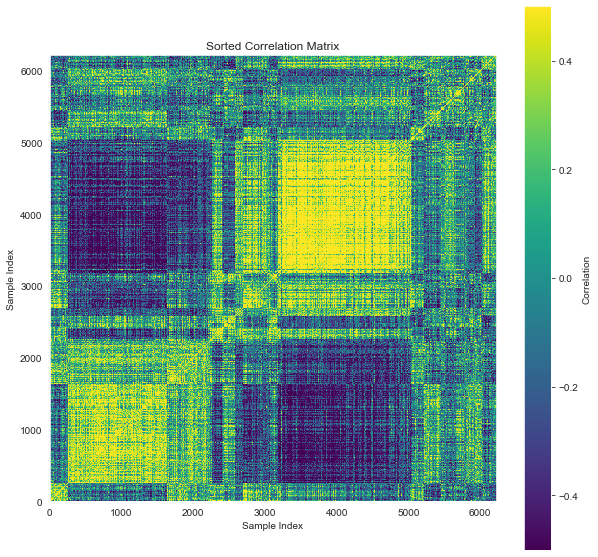

In [65]:
# plot the sorted correlation matrix to understand if sorting worked, and identify correct clustering for further analysis
fig = plt.figure(figsize=(10, 10))
plt.imshow(sorted_correlation_matrix, cmap='viridis', interpolation='nearest', vmin=-0.5, vmax=0.5, origin='lower')
plt.colorbar(label='Correlation')
plt.title('Sorted Correlation Matrix')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')
plt.grid(False)  # Turn off gridlines

plt.show()
fig.savefig(r'D:\bsa_project\correlation_matrix.pdf')

In [90]:
# manual selection of clusters because I got confused by the clustering dictionary:
cluster_1 = sorted_psd[500:1500,:]
cluster_2 = sorted_psd[3500:5000,:]

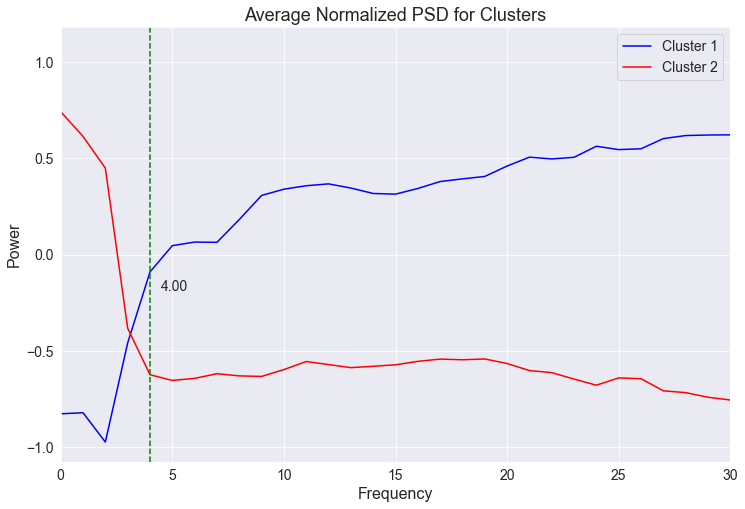

In [92]:
# find the transition frequency for the sleep cycles:
# Calculate the average PSD for each cluster
avg_psd_cluster_1 = np.mean(cluster_1, axis=0)
avg_psd_cluster_2 = np.mean(cluster_2, axis=0)

# Find the transition frequency
switch_index = None
for i in range(1, len(f)):
    if avg_psd_cluster_1[i] > avg_psd_cluster_2[i] and avg_psd_cluster_1[i - 1] < avg_psd_cluster_2[i - 1]:
        switch_index = i
        break
    elif avg_psd_cluster_1[i] < avg_psd_cluster_2[i] and avg_psd_cluster_1[i - 1] > avg_psd_cluster_2[i - 1]:
        switch_index = i
        break

# Plot the average PSD for each cluster
fig = plt.figure(figsize=(12, 8))  # Increase plot size
plt.plot(f, avg_psd_cluster_1, label='Cluster 1', color='blue')
plt.plot(f, avg_psd_cluster_2, label='Cluster 2', color='red')
plt.xlabel('Frequency', fontsize=16)  # Increase font size
plt.ylabel('Power', fontsize=16)  # Increase font size
plt.title('Average Normalized PSD for Clusters', fontsize=18)  # Increase font size
plt.legend(fontsize=14)  # Increase font size
plt.grid(True)

# Set x-axis limit
plt.xlim(0, 30)

# Plot vertical line at the transition frequency
if switch_index is not None:
    switch_frequency = f[switch_index]
    plt.axvline(x=switch_frequency, color='green', linestyle='--')
    plt.text(switch_frequency + 0.5, max(avg_psd_cluster_1[switch_index], avg_psd_cluster_2[switch_index]) - 0.1,
             f'{switch_frequency:.2f}', fontsize=14)  # Increase font size and adjust position

# Increase tick label font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()
#fig.savefig(r'D:\bsa_project\PowerCrossover.pdf')

In [94]:
# Define frequency windows
delta_window = (0, 4)  #  Hz
beta_window = (10, 30)  #  Hz

# Find indices corresponding to delta and beta frequency windows
delta_indices = np.where((f >= delta_window[0]) & (f <= delta_window[1]))[0]
beta_indices = np.where((f >= beta_window[0]) & (f <= beta_window[1]))[0]

# Calculate mean power within each frequency window for each row
delta_mean_power = np.mean(power_spectra[:, delta_indices], axis=1)
beta_mean_power = np.mean(power_spectra[:, beta_indices], axis=1)

# Calculate the ratio of power between delta and beta frequency windows for each row
delta_beta_ratio = delta_mean_power / beta_mean_power # Output is a single vector corresponding to delta/beta power for each 10-second bin

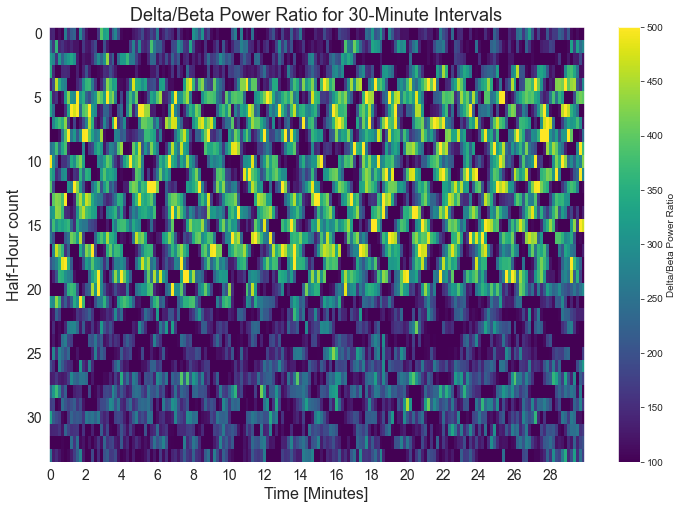

In [103]:
# Calculate the number of samples per 30 minutes
samples_per_30_minutes = int(30 * 60 / 10)  # Assuming each sample is 10 seconds

# Reshape delta_beta_ratio into a matrix
num_30_minutes_intervals = len(delta_beta_ratio) // samples_per_30_minutes
delta_beta_matrix = np.reshape(delta_beta_ratio[:num_30_minutes_intervals * samples_per_30_minutes],
                               (num_30_minutes_intervals, samples_per_30_minutes))

# Calculate the number of minutes corresponding to each tick mark on the X-axis
num_ticks = len(delta_beta_matrix[0])  # Number of columns in the matrix
minutes_per_sample = 10 / 60  # Each sample is 10 seconds, so there are 6 samples per minute
tick_locations = np.arange(0, num_ticks, step=12)  # Tick locations every 6 samples (1 minute)

# Set the tick labels on the X-axis to correspond to minutes
tick_labels = [f'{i * minutes_per_sample:.0f}' for i in range(0, num_ticks, 12)]
# Plot the resulting matrix using imshow with larger font sizes
fig = plt.figure(figsize=(12, 8))
plt.imshow(delta_beta_matrix, aspect='auto', cmap='viridis', interpolation='nearest', vmax=500, vmin=100)
plt.colorbar(label='Delta/Beta Power Ratio')
plt.title('Delta/Beta Power Ratio for 30-Minute Intervals', fontsize=18)  # Increase title font size
plt.xlabel('Time [Minutes]', fontsize=16)
plt.ylabel('Half-Hour count', fontsize=16)  # Increase y-axis label font size
plt.xticks(tick_locations, tick_labels, fontsize=14) 
plt.yticks(fontsize=14)  # Increase y-axis tick label font size
plt.grid(False)
plt.show()
fig.savefig(r'D:\bsa_project\DeltaBetaRatioWholeNight.pdf')

In [105]:
# analyze the length of the average sleep cycle by looking at the middle of the night and averaging:
# Step 1: Calculate Autocorrelation for a 4-Hour Window
four_hour_window = delta_beta_ratio[(4 * 3600 // 10):(4 * 3600 // 10)*2]  # 4-hour window (3600 seconds per hour, each sample is 10 seconds)
autocorr = np.correlate(four_hour_window, four_hour_window, mode='full')

# Step 2: Extract Global Oscillation Period and Anti-phase Lag
positive_peaks, _ = scipy.signal.find_peaks(autocorr)
negative_peaks, _ = scipy.signal.find_peaks(-autocorr)
global_oscillation_period = positive_peaks[0] * 10  # Convert index to seconds
global_anti_phase_lag = negative_peaks[0] * 10  # Convert index to seconds

# Steps 3-5: Calculate Scrolling Autocorrelation, Smooth, and Locate Local Period and Anti-phase Lag
rolling_autocorr = np.correlate(delta_beta_ratio, delta_beta_ratio, mode='full')
rolling_autocorr_smoothed = np.convolve(rolling_autocorr, np.ones(10)/10, mode='same')
local_periods = []
local_anti_phase_lags = []
for i in range(len(rolling_autocorr_smoothed) - 1000):  # 1000-second bins
    bin_autocorr = rolling_autocorr_smoothed[i:i+1000]
    local_positive_peaks, _ = scipy.signal.find_peaks(bin_autocorr)
    local_negative_peaks, _ = scipy.signal.find_peaks(-bin_autocorr)
    local_periods.append(local_positive_peaks[0] * 10)  # Convert index to seconds
    local_anti_phase_lags.append(local_negative_peaks[0] * 10)  # Convert index to seconds

# Step 6: Identify "Sleep" Bins
autocorr_difference = np.abs(np.array(local_periods) - np.array(local_anti_phase_lags))
sleep_bins = np.where(autocorr_difference > 0.25)[0]

# Step 7: Median Filtering and Binarization
median_filtered = scipy.signal.medfilt(np.array(sleep_bins), kernel_size=361)  # 1-hour window
binary_series = (median_filtered >= 0.5).astype(int)


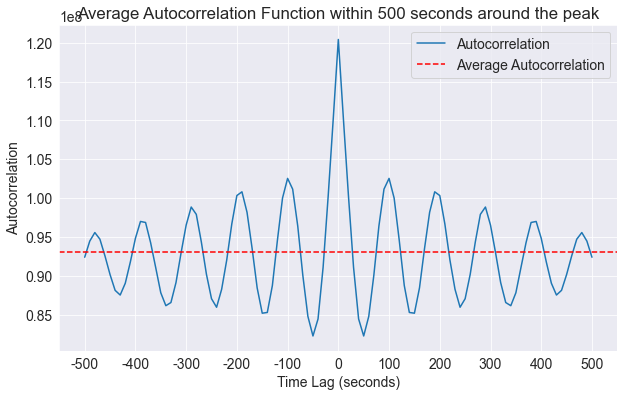

In [117]:
# Calculate the range around the average peak
peak_range = 500  # in seconds
avg_peak_index = np.argmax(autocorr)
start_index = max(avg_peak_index - (peak_range // 10), 0)  # Convert seconds to samples (10-second intervals)
end_index = min(avg_peak_index + (peak_range // 10), len(autocorr))

# Calculate the average autocorrelation function within the range
avg_autocorr_range = np.mean(autocorr[start_index:end_index + 1])

# Plot the average autocorrelation function within the range
fig = plt.figure(figsize=(10, 6))
plt.plot(np.arange(start_index, end_index + 1) * 10, autocorr[start_index:end_index + 1], label='Autocorrelation')
plt.axhline(y=avg_autocorr_range, color='r', linestyle='--', label='Average Autocorrelation')
plt.xlabel('Time Lag (seconds)',fontsize=14)
plt.ylabel('Autocorrelation',fontsize=14)
plt.title(f'Average Autocorrelation Function within {peak_range} seconds around the peak', fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)

# Set x-axis tick labels to be centered around the middle peak
ticks_middle_peak = np.arange(-peak_range, peak_range + 1, 100)
plt.xticks(ticks_middle_peak + avg_peak_index * 10, ticks_middle_peak)

plt.show()
#fig.savefig(r'D:\bsa_project\Autocorrelation_function_for_sleep_cycles.pdf')

In [21]:
pickle_path = pathlib.Path(r'D:\bsa_project\sleepEPhys_downsampled.pickl')
with open(pickle_path,'rb') as file:
    data = pickle.load(file=file)
    

In [22]:
ms_timestamps = range(len(data))
# Parameters
window_sec = 10  # in seconds
window_samples = window_sec * 1000  # Convert to milliseconds for data with sampling rate of 1000Hz
step_size = 1000  # in milliseconds

# Initialize lists to store delta/beta ratios and their corresponding time indices
ratios = []
time_indices = []
beta_powers = []
delta_powers = []
# Iterate over the data with the specified step size and compute delta/beta ratios for each window
for i in range(0, len(data) - window_length + 1, step_size):
    window_data = data[i:i + window_length]

    # Compute the power spectral density (PSD) using Welch's method
    frequencies, psd = welch(window_data, fs=1000)

    # Define frequency ranges
    delta_freq_range = (1, 8)
    beta_freq_range = (14, 20)

    # Find indices corresponding to delta and beta frequency ranges
    delta_idx = np.where((frequencies >= delta_freq_range[0]) & (frequencies <= delta_freq_range[1]))[0]
    beta_idx = np.where((frequencies >= beta_freq_range[0]) & (frequencies <= beta_freq_range[1]))[0]

    # Compute power in delta and beta frequency ranges
    power_delta = np.trapz(psd[delta_idx], frequencies[delta_idx])
    power_beta = np.trapz(psd[beta_idx], frequencies[beta_idx])

    # Compute the ratio between delta and beta power
    delta_beta_ratio = power_delta / power_beta

    # Append the ratio and its corresponding time index to the lists
    ratios.append(delta_beta_ratio)
    delta_powers.append(power_delta)
    beta_powers.append(power_beta)
    time_indices.append(i)  # Convert time index to seconds


In [32]:
window_sec = 10  # in seconds
window_samples = window_sec * 1000  # Convert to milliseconds for data with sampling rate of 1000Hz
step_size = 1000
range(0, len(data), step_size)
expected_windows = len(data) / step_size
expected_windows

3604.48

In [34]:
# the following assumes a hexadecimal encoding scheme for the bytes object

# Calculate the number of integers in the data
num_integers = len(bin_data) // 2

# Pre-allocate an array of zeros to store the decoded integers
decoded_integers_array = np.zeros(num_integers, dtype=int)

# Define a generator expression to yield decoded integers
decoded_integers_gen = (int(bin_data[i:i+2].hex(), 16) for i in range(0, len(bin_data), 2))

# Use tqdm with the generator expression to display a progress bar
for i, integer in tqdm.tqdm(enumerate(decoded_integers_gen), total=num_integers, desc='Decoding Progress'):
    # Assign each decoded integer to its correct place in the array
    decoded_integers_array[i] = integer

# Now you have the decoded integers collected in a NumPy array


Decoding Progress: 100%|██████████| 1991234017/1991234017 [20:54<00:00, 1587565.49it/s]


In [35]:
with open(r'D:\bsa_project\sleepEPhys_decoded.pkl','wb') as file:
    pickle.dump(decoded_integers_array, file=file)

In [45]:
def decimation_filter(neuro_data, original_sampling_rate, target_sampling_rate, chunk_size):
    # Define the cutoff frequency for the low-pass filter
    nyquist_frequency = 0.5 * original_sampling_rate
    cutoff_frequency = 0.4 * target_sampling_rate

    # Design a low-pass Butterworth filter
    b, a = butter(8, cutoff_frequency / nyquist_frequency, btype='low')

    # Calculate the number of samples in each chunk
    num_samples = len(neuro_data)
    num_chunks = (num_samples + chunk_size - 1) // chunk_size
    print(f'chunks to downsample: {num_chunks}')
    # Initialize an empty array to store the downsampled data
    downsampled_data = np.zeros((num_chunks, int(chunk_size * target_sampling_rate / original_sampling_rate)), dtype=neuro_data.dtype)

    # Process each chunk
    for i in range(num_chunks):
        print(f'downsampling chunk # {i} of {num_chunks}', end='\r')
        # Get the start and end indices of the current chunk
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, num_samples)

        # Extract the current chunk of data
        chunk = neuro_data[start_idx:end_idx]

        # Apply the low-pass filter to the current chunk
        filtered_chunk = filtfilt(b, a, chunk)

        # Downsample the filtered chunk to the target sampling rate
        downsampled_chunk = resample(filtered_chunk, int(chunk_size * target_sampling_rate / original_sampling_rate))

        # Store the downsampled chunk in the output array
        downsampled_data[i, :len(downsampled_chunk)] = downsampled_chunk
    downsampled_data_series = np.ravel(downsampled_data)
    
    return downsampled_data_series

In [46]:
original_sampling_rate = 32000
target_sampling_rate = 1000

chunk_size = 1024**2  # Adjust the chunk size according to your memory constraints
overall_hours = 17.285
whole_segments = 17
baseline_path = pathlib.Path(r'D:\bsa_project\downsampled_collection')
for segment in range(whole_segments+1):
    print(f'working on segment {segment}')
    if segment < 17:
        current_data_segment = decoded_integers_array[segment*int(3600*32000):int(3600*32000)+int(3600*32000*segment)]
    elif segment == 17:
        current_data_segment = decoded_integers_array[segment*int(3600*32000):]
    current_downsampled_data = downsample_neuro_data_chunked(current_data_segment,
                                                             original_sampling_rate,
                                                             target_sampling_rate,
                                                             chunk_size)
    p = baseline_path / f'data_segment_{segment}.pkl'
    with open(p,'wb') as file:
        pickle.dump(current_downsampled_data,file)


working on segment 0
chunks to downsample: 110
working on segment 1 109 of 110
chunks to downsample: 110
working on segment 2 109 of 110
chunks to downsample: 110
working on segment 3 109 of 110
chunks to downsample: 110
working on segment 4 109 of 110
chunks to downsample: 110
working on segment 5 109 of 110
chunks to downsample: 110
working on segment 6 109 of 110
chunks to downsample: 110
working on segment 7 109 of 110
chunks to downsample: 110
working on segment 8 109 of 110
chunks to downsample: 110
working on segment 9 109 of 110
chunks to downsample: 110
working on segment 10109 of 110
chunks to downsample: 110
working on segment 11109 of 110
chunks to downsample: 110
working on segment 12109 of 110
chunks to downsample: 110
working on segment 13109 of 110
chunks to downsample: 110
working on segment 14109 of 110
chunks to downsample: 110
working on segment 15109 of 110
chunks to downsample: 110
working on segment 16109 of 110
chunks to downsample: 110
working on segment 17109 

In [ ]:
with open(r'D:\bsa_project\sleepEPhys_downsampled.pickl','wb') as file:
    pickle.dump(downsampled_data, file=file)
    

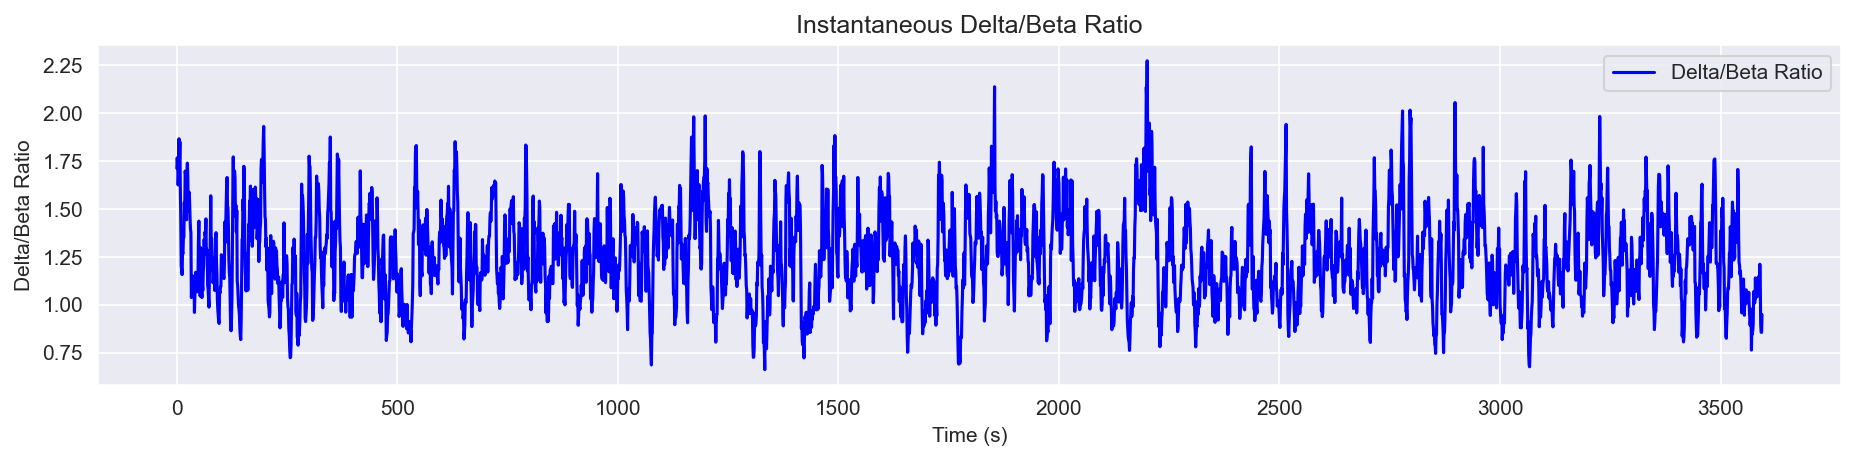

In [6]:
# plot a single hour:
#data = downsampled_data

# Parameters
window_size = 10  # in seconds
window_length = window_size * 1000  # Convert to milliseconds for data with sampling rate of 1000Hz
step_size = 1000  # in milliseconds

# Initialize lists to store delta/beta ratios and their corresponding time indices
ratios = []
time_indices = []

# Iterate over the data with the specified step size and compute delta/beta ratios for each window
for i in range(0, len(data) - window_length + 1, step_size):
    window_data = data[i:i + window_length]

    # Compute the power spectral density (PSD) using Welch's method
    frequencies, psd = welch(window_data, fs=1000, nperseg=1024)

    # Define frequency ranges
    delta_freq_range = (1, 8)
    beta_freq_range = (14, 20)

    # Find indices corresponding to delta and beta frequency ranges
    delta_idx = np.where((frequencies >= delta_freq_range[0]) & (frequencies <= delta_freq_range[1]))[0]
    beta_idx = np.where((frequencies >= beta_freq_range[0]) & (frequencies <= beta_freq_range[1]))[0]

    # Compute power in delta and beta frequency ranges
    power_delta = np.trapz(psd[delta_idx], frequencies[delta_idx])
    power_beta = np.trapz(psd[beta_idx], frequencies[beta_idx])

    # Compute the ratio between delta and beta power
    delta_beta_ratio = power_delta / power_beta

    # Append the ratio and its corresponding time index to the lists
    ratios.append(delta_beta_ratio)
    time_indices.append(i / 1000)  # Convert time index to seconds

# Plot the instantaneous delta/beta ratio
plt.figure(figsize=(15,  3),dpi=150)
plt.plot(time_indices, ratios, label='Delta/Beta Ratio', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Delta/Beta Ratio')
plt.title('Instantaneous Delta/Beta Ratio')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# This iterates over the entire recording:
# Initialize lists to store delta/beta ratios and their corresponding time indices for the entire recording
all_ratios = []
all_time_indices = []

# Iterate over the entire recording, processing one hour at a time
num_hours = 17
for hour in range(num_hours):
    print(f"Processing hour {hour+1}/{num_hours}")
    
    # Extract data for the current hour
    start_idx = hour * 3600 * original_sampling_rate
    end_idx = min(start_idx + 3600 * original_sampling_rate, len(decoded_integers_array))
    neuro_data_hour = decoded_integers_array[start_idx:end_idx]
    
    # Downsample the data for the current hour
    downsampled_data_hour = downsample_neuro_data_chunked(neuro_data_hour, original_sampling_rate, target_sampling_rate, chunk_size)
    
    # Initialize lists to store delta/beta ratios and their corresponding time indices for the current hour
    ratios_hour = []
    time_indices_hour = []

    # Iterate over the data with the specified step size and compute delta/beta ratios for each window
    for i in range(0, len(downsampled_data_hour) - window_length + 1, step_size):
        window_data_hour = downsampled_data_hour[i:i + window_length]

        # Compute the power spectral density (PSD) using Welch's method
        frequencies_hour, psd_hour = welch(window_data_hour, fs=target_sampling_rate, nperseg=1024)

        # Define frequency ranges
        delta_freq_range = (0.5, 4)
        beta_freq_range = (10, 30)

        # Find indices corresponding to delta and beta frequency ranges
        delta_idx = np.where((frequencies_hour >= delta_freq_range[0]) & (frequencies_hour <= delta_freq_range[1]))[0]
        beta_idx = np.where((frequencies_hour >= beta_freq_range[0]) & (frequencies_hour <= beta_freq_range[1]))[0]

        # Compute power in delta and beta frequency ranges
        power_delta = np.trapz(psd_hour[delta_idx], frequencies_hour[delta_idx])
        power_beta = np.trapz(psd_hour[beta_idx], frequencies_hour[beta_idx])

        # Compute the ratio between delta and beta power
        delta_beta_ratio_hour = power_delta / power_beta

        # Append the ratio and its corresponding time index to the lists for the current hour
        ratios_hour.append(delta_beta_ratio_hour)
        time_indices_hour.append(i / 1000)  # Convert time index to seconds

    # Append ratios and time indices for the current hour to the lists for the entire recording
    all_ratios.append(ratios_hour)
    all_time_indices.append(time_indices_hour)



In [ ]:
all_ratios_rev = np.array(all_ratios[::-1]).T

# Plot the entire recording's delta-to-beta ratio
plt.figure(figsize=(15, 5), dpi=150)
plt.imshow(all_ratios_rev, aspect='auto', cmap='viridis', extent=[0, num_hours, 0, 3600], origin='lower', vmin=0, vmax=2)
plt.colorbar(label='Delta/Beta Ratio')
plt.xlabel('Hour')
plt.ylabel('Time (s)')
plt.title('Delta/Beta Ratio Throughout Recording')
plt.grid(True)
plt.show()

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# Assuming your numpy array is named 'data'
data = np.array(all_ratios)

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 2),dpi=200)

# Plot the data using imshow
im = ax.imshow(data, aspect='auto', cmap='viridis', origin='upper', clim=(0.5, 2))

# Set labels and title
ax.set_xlabel('Seconds within each hour')
ax.set_ylabel('Hours')
ax.set_title('DB ratio heatmap')
ax.grid(False)
# Add a colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Delta / Beta ratio')

# Set the colorbar ticks
cbar.set_ticks(np.linspace(0, 2, num=5))

# Show the plot
plt.show()

#fig.savefig(r'D:\bsa_project\db_ratio_heatmap.pdf')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your numpy array is named 'data'
data = np.array(all_ratios)

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 2), dpi=200)

# Plot the data using imshow
im = ax.imshow(data, aspect='auto', cmap='viridis', origin='upper', clim=(0, 2))

# Set labels and title
ax.set_xlabel('Seconds within each hour')
ax.set_ylabel('Hours')
ax.set_title('DB ratio heatmap')
ax.grid(False)

# Add horizontal lines separating each hour (row)
for i in range(data.shape[0]):
    ax.axhline(i + 0.5, color='black', linewidth=0.5)

# Add a colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Delta / Beta ratio')

# Set the colorbar ticks
cbar.set_ticks(np.linspace(0, 2, num=5))

# Show the plot
plt.show()

#fig.savefig(r'D:\bsa_project\db_ratio_heatmap.pdf')
